In [1]:
from ClassiPyGRB import SWIFT
# Packages needed for this notebook
import os
import numpy as np

In [2]:
import torch
import torch.nn as nn
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [3]:
%matplotlib inline
swift = SWIFT(root_path=r'data', res=64, n_bands=[1,2,3,4,5])
print(f"Swift/BAT bands selected: {swift.bands_selected}")

Swift/BAT bands selected: ['Time(s)', '15-25keV', '25-50keV', '50-100keV', '100-350keV', '15-350keV']


In [4]:
data_loaded = np.load(os.path.join(swift.results_path, f'SWIFT_Noise_Reduced_data_{swift.res}res_{"".join(str(b) for b in swift.n_bands)}bands_DFT_True.npz'))
grb_names, features = data_loaded['names'], data_loaded['data']
durations = swift.total_durations(grb_names, t=90)

Finding Durations: 100%|██████████████████| 1513/1513 [00:10<00:00, 144.23GRB/s]


In [5]:
features.shape

(1513, 48000)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


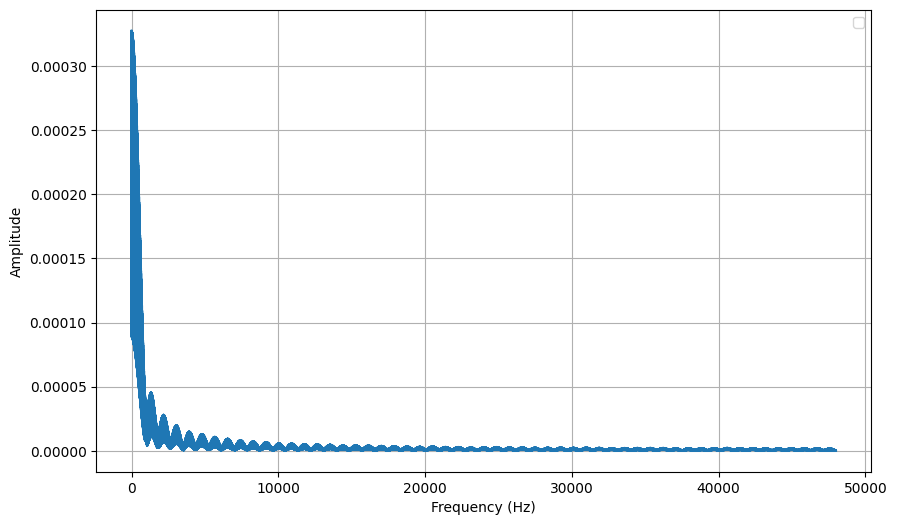

In [6]:
x = np.linspace(0, features.shape[1], features.shape[1])

plt.figure(figsize=(10, 6))
plt.plot(x, features[0])  # Converting tensor to numpy array for plotting
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

plt.legend()
plt.grid(True)

In [7]:
features = features[:,:1000]
features.shape

(1513, 1000)

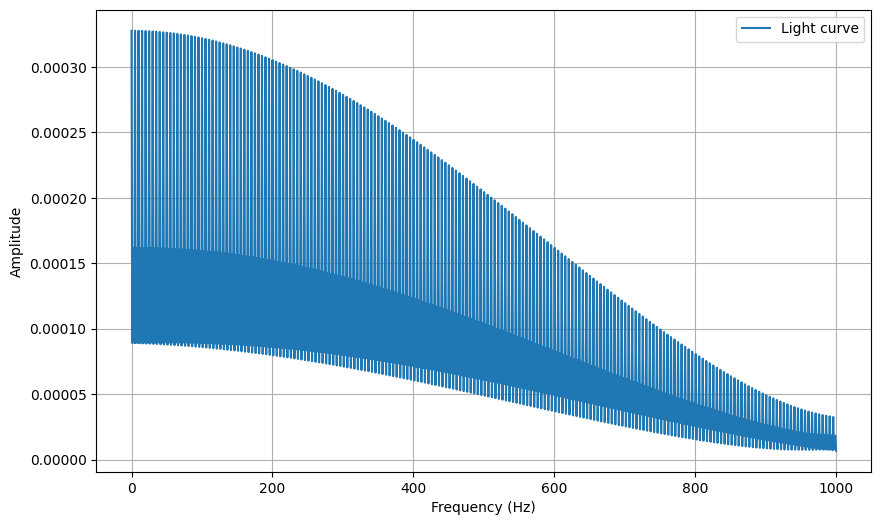

In [8]:
x = np.linspace(0, features.shape[1], features.shape[1])

plt.figure(figsize=(10, 6))
plt.plot(x, features[0], label='Light curve')  # Converting tensor to numpy array for plotting
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

In [9]:
# Normalize the features here
normalized_features = (features - np.mean(features, axis=1, keepdims=1))/np.std(features,axis=1,keepdims=1)
print(normalized_features.shape)
print(np.mean(normalized_features,axis=1))
print(np.std(normalized_features,axis=1))

(1513, 1000)
[0.00000000e+00 5.68434189e-17 1.13686838e-16 ... 1.13686838e-16
 5.68434189e-17 0.00000000e+00]
[1. 1. 1. ... 1. 1. 1.]


In [10]:
_normalized_features = normalized_features # copy this so rerunning next cell doesn't throw error
_labels = np.zeros(shape=(normalized_features.shape[0],1))

In [11]:
normalized_features = torch.from_numpy(_normalized_features).to(torch.float32)
labels = torch.from_numpy(_labels).to(torch.float32)

In [12]:

# Split the cleaned data into training and testing sets
X_train, X_test, class_train, class_test = train_test_split(normalized_features, labels, test_size=0.2, random_state=205)


training_dataset = TensorDataset(X_train, class_train)
test_dataset = TensorDataset(X_test, class_test)

BATCHSIZE = 128
BATCHSIZE_TEST = 64

train_dataloader = DataLoader(training_dataset, batch_size=BATCHSIZE, shuffle=True)
test_dataloader  = DataLoader(test_dataset, batch_size=BATCHSIZE_TEST, shuffle=True)

In [13]:
INPUT_SIZE      = features.shape[1]
LATENT_SIZE     = 3
HIDDEN_SIZE_1     = 100

In [14]:
# Note that this code is largely from https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions/tree/main/Sessions/Session14
# First, we will inherit from pytorch Module class; https://pytorch.org/docs/stable/generated/torch.nn.Module.html

class Encoder(nn.Module):
    def __init__(self, seed=205):
        """
        seed: int, random seed for reproducibility
        """
        super(Encoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        # here we are initializing the linear layers. This registeres the layer parameters (W,b) as parameters of the Module
        self.fc1 = nn.Linear(INPUT_SIZE,HIDDEN_SIZE_1)
        self.fc2 = nn.Linear(HIDDEN_SIZE_1,LATENT_SIZE)

        # We will initialize weights following a multivariate Gaussian
        nn.init.normal_(self.fc1.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc1.bias, mean=0, std=0.01)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc2.bias, mean=0, std=0.01)

    # this defines a forward pass of the network (="applying" the network to some input data)
    def forward(self, x):
        # print(x.dtype)
        # print(self.fc1.weight.dtype)
        # print(self.fc1.bias.dtype) # for debugging dtype mismatch
        x      = torch.nn.LeakyReLU()(self.fc1(x))
        z      = self.fc2(x)
        return z

class Decoder(nn.Module):
    def __init__(self, seed=205):
        """
        seed: int, random seed for reproducibility
        """
        super(Decoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        # Using the encoder, how will you initialize two layers?
        self.fc1 = nn.Linear(LATENT_SIZE,HIDDEN_SIZE_1)
        self.fc2 = nn.Linear(HIDDEN_SIZE_1,INPUT_SIZE)

        # Using the endoer, how will you initialize the weights and biases?
        nn.init.normal_(self.fc1.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc1.bias, mean=0, std=0.01)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc2.bias, mean=0, std=0.01)

    def forward(self, z):
        # Using the encoder, how will you define the forward pass?
        # I recommend the same activation function!
        z      = torch.nn.LeakyReLU()(self.fc1(z))
        x      = self.fc2(z)
        return x

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # here we are creating instances of the Encoder and Decoder class
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x

In [15]:
# This creates an instance of the Autoencoder class
AE = Autoencoder()

In [16]:
# the training loop takes a function that loads the data batch by batch, a model to train, a loss function to train the model on and an optimizer
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    losses = []
    # iterate over the dataset
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction of the model
        pred = model(X)
        # Compute the loss function
        loss = loss_fn(pred,X)

        # Backpropagation; this is where we take the gradient and update the network parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # here we keep track of the loss
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            losses.append(loss)
            print(f"train loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return losses

# the test loop is similar to the training loop, only that we don't take any gradients/don't update the network parameters, but only evaluate
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss =  0
    with torch.no_grad():
        for (X, y) in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, X).item()

    test_loss /= num_batches
    print(f" Avg test loss: {test_loss:>8f} \n")

    return test_loss

In [17]:
features.shape

(1513, 1000)

In [18]:
from tqdm import tqdm

EPOCHS = 200
LEARNING_RATE = 1e-3


# MeanSquaredError (L2) Loss
loss_fn         = nn.MSELoss()
# Adam Optimizer
optimizer       = torch.optim.Adam(AE.parameters(), lr=LEARNING_RATE)


train_loss = []
test_loss  = []
for t in tqdm(range(EPOCHS)):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss.append(train_loop(train_dataloader, AE, loss_fn, optimizer))
    test_loss.append(test_loop(test_dataloader, AE, loss_fn))
print("Done!")

  0%|                                                   | 0/200 [00:00<?, ?it/s]

Epoch 1
-------------------------------
train loss: 1.000720  [    0/ 1210]


  1%|▍                                          | 2/200 [00:00<00:37,  5.34it/s]

 Avg test loss: 0.944834 

Epoch 2
-------------------------------
train loss: 0.945439  [    0/ 1210]
 Avg test loss: 0.604334 

Epoch 3
-------------------------------
train loss: 0.627455  [    0/ 1210]


  2%|▋                                          | 3/200 [00:00<00:52,  3.75it/s]

 Avg test loss: 0.443531 

Epoch 4
-------------------------------
train loss: 0.453954  [    0/ 1210]


  2%|▊                                          | 4/200 [00:01<01:17,  2.53it/s]

 Avg test loss: 0.350074 

Epoch 5
-------------------------------
train loss: 0.323909  [    0/ 1210]


  2%|█                                          | 5/200 [00:04<04:26,  1.37s/it]

 Avg test loss: 0.299326 

Epoch 6
-------------------------------
train loss: 0.309777  [    0/ 1210]


  3%|█▎                                         | 6/200 [00:07<05:59,  1.85s/it]

 Avg test loss: 0.281824 

Epoch 7
-------------------------------
train loss: 0.277331  [    0/ 1210]


  4%|█▌                                         | 7/200 [00:07<04:35,  1.43s/it]

 Avg test loss: 0.274359 

Epoch 8
-------------------------------
train loss: 0.276108  [    0/ 1210]


  4%|█▋                                         | 8/200 [00:09<04:54,  1.53s/it]

 Avg test loss: 0.271643 

Epoch 9
-------------------------------
train loss: 0.266630  [    0/ 1210]


  4%|█▉                                         | 9/200 [00:12<06:14,  1.96s/it]

 Avg test loss: 0.273127 

Epoch 10
-------------------------------
train loss: 0.278047  [    0/ 1210]


  5%|██                                        | 10/200 [00:15<07:39,  2.42s/it]

 Avg test loss: 0.272467 

Epoch 11
-------------------------------
train loss: 0.256635  [    0/ 1210]


  6%|██▎                                       | 11/200 [00:16<05:40,  1.80s/it]

 Avg test loss: 0.273381 

Epoch 12
-------------------------------
train loss: 0.268248  [    0/ 1210]


  6%|██▌                                       | 12/200 [00:16<04:26,  1.42s/it]

 Avg test loss: 0.270604 

Epoch 13
-------------------------------
train loss: 0.281443  [    0/ 1210]


  6%|██▋                                       | 13/200 [00:17<03:19,  1.07s/it]

 Avg test loss: 0.270447 

Epoch 14
-------------------------------
train loss: 0.267909  [    0/ 1210]


  7%|██▉                                       | 14/200 [00:17<02:37,  1.18it/s]

 Avg test loss: 0.270133 

Epoch 15
-------------------------------
train loss: 0.292224  [    0/ 1210]


  8%|███▎                                      | 16/200 [00:18<02:13,  1.38it/s]

 Avg test loss: 0.271428 

Epoch 16
-------------------------------
train loss: 0.267620  [    0/ 1210]
 Avg test loss: 0.269327 

Epoch 17
-------------------------------
train loss: 0.275556  [    0/ 1210]


  9%|███▊                                      | 18/200 [00:19<01:21,  2.24it/s]

 Avg test loss: 0.268524 

Epoch 18
-------------------------------
train loss: 0.271289  [    0/ 1210]
 Avg test loss: 0.264768 

Epoch 19
-------------------------------
train loss: 0.265491  [    0/ 1210]


 10%|████▏                                     | 20/200 [00:19<00:54,  3.33it/s]

 Avg test loss: 0.254849 

Epoch 20
-------------------------------
train loss: 0.248402  [    0/ 1210]
 Avg test loss: 0.210361 

Epoch 21
-------------------------------
train loss: 0.203780  [    0/ 1210]


 11%|████▌                                     | 22/200 [00:19<00:39,  4.55it/s]

 Avg test loss: 0.167639 

Epoch 22
-------------------------------
train loss: 0.163568  [    0/ 1210]
 Avg test loss: 0.148629 

Epoch 23
-------------------------------
train loss: 0.146412  [    0/ 1210]


 12%|█████                                     | 24/200 [00:20<00:33,  5.28it/s]

 Avg test loss: 0.135885 

Epoch 24
-------------------------------
train loss: 0.143151  [    0/ 1210]
 Avg test loss: 0.122232 

Epoch 25
-------------------------------
train loss: 0.112164  [    0/ 1210]


 13%|█████▍                                    | 26/200 [00:20<00:26,  6.66it/s]

 Avg test loss: 0.114510 

Epoch 26
-------------------------------
train loss: 0.130253  [    0/ 1210]
 Avg test loss: 0.109832 

Epoch 27
-------------------------------
train loss: 0.098509  [    0/ 1210]


 14%|█████▉                                    | 28/200 [00:20<00:29,  5.88it/s]

 Avg test loss: 0.105953 

Epoch 28
-------------------------------
train loss: 0.114510  [    0/ 1210]
 Avg test loss: 0.104779 

Epoch 29
-------------------------------


 14%|██████                                    | 29/200 [00:20<00:30,  5.53it/s]

train loss: 0.100042  [    0/ 1210]
 Avg test loss: 0.101827 

Epoch 30
-------------------------------
train loss: 0.101233  [    0/ 1210]


 16%|██████▌                                   | 31/200 [00:21<00:28,  6.02it/s]

 Avg test loss: 0.099232 

Epoch 31
-------------------------------
train loss: 0.108231  [    0/ 1210]
 Avg test loss: 0.099381 

Epoch 32
-------------------------------
train loss: 0.092430  [    0/ 1210]


 16%|██████▉                                   | 33/200 [00:21<00:24,  6.88it/s]

 Avg test loss: 0.097418 

Epoch 33
-------------------------------
train loss: 0.099566  [    0/ 1210]
 Avg test loss: 0.096297 

Epoch 34
-------------------------------
train loss: 0.104148  [    0/ 1210]


 18%|███████▎                                  | 35/200 [00:21<00:22,  7.40it/s]

 Avg test loss: 0.095778 

Epoch 35
-------------------------------
train loss: 0.105104  [    0/ 1210]
 Avg test loss: 0.096082 

Epoch 36
-------------------------------
train loss: 0.097834  [    0/ 1210]


 18%|███████▊                                  | 37/200 [00:22<00:22,  7.15it/s]

 Avg test loss: 0.093938 

Epoch 37
-------------------------------
train loss: 0.108481  [    0/ 1210]
 Avg test loss: 0.094068 

Epoch 38
-------------------------------
train loss: 0.092004  [    0/ 1210]


 20%|████████▏                                 | 39/200 [00:22<00:23,  6.86it/s]

 Avg test loss: 0.093213 

Epoch 39
-------------------------------
train loss: 0.099630  [    0/ 1210]
 Avg test loss: 0.091653 

Epoch 40
-------------------------------
train loss: 0.084163  [    0/ 1210]


 20%|████████▍                                 | 40/200 [00:22<00:24,  6.50it/s]

 Avg test loss: 0.092026 

Epoch 41
-------------------------------
train loss: 0.100152  [    0/ 1210]


 20%|████████▌                                 | 41/200 [00:22<00:27,  5.81it/s]

 Avg test loss: 0.090960 

Epoch 42
-------------------------------
train loss: 0.091494  [    0/ 1210]
 Avg test loss: 0.092217 

Epoch 43
-------------------------------
train loss: 0.099614  [    0/ 1210]


 22%|█████████▏                                | 44/200 [00:23<00:22,  6.83it/s]

 Avg test loss: 0.091505 

Epoch 44
-------------------------------
train loss: 0.090534  [    0/ 1210]
 Avg test loss: 0.089307 

Epoch 45
-------------------------------
train loss: 0.086566  [    0/ 1210]


 22%|█████████▍                                | 45/200 [00:23<00:33,  4.66it/s]

 Avg test loss: 0.089763 

Epoch 46
-------------------------------
train loss: 0.086953  [    0/ 1210]


 24%|█████████▊                                | 47/200 [00:24<00:53,  2.86it/s]

 Avg test loss: 0.089139 

Epoch 47
-------------------------------
train loss: 0.090148  [    0/ 1210]
 Avg test loss: 0.088710 

Epoch 48
-------------------------------
train loss: 0.110783  [    0/ 1210]


 24%|██████████▎                               | 49/200 [00:24<00:38,  3.92it/s]

 Avg test loss: 0.088452 

Epoch 49
-------------------------------
train loss: 0.092848  [    0/ 1210]
 Avg test loss: 0.088171 

Epoch 50
-------------------------------
train loss: 0.097825  [    0/ 1210]


 26%|██████████▋                               | 51/200 [00:25<00:28,  5.20it/s]

 Avg test loss: 0.088354 

Epoch 51
-------------------------------
train loss: 0.098311  [    0/ 1210]
 Avg test loss: 0.089307 

Epoch 52
-------------------------------
train loss: 0.093952  [    0/ 1210]


 26%|███████████▏                              | 53/200 [00:25<00:25,  5.71it/s]

 Avg test loss: 0.088256 

Epoch 53
-------------------------------
train loss: 0.082240  [    0/ 1210]
 Avg test loss: 0.086998 

Epoch 54
-------------------------------
train loss: 0.090756  [    0/ 1210]


 28%|███████████▌                              | 55/200 [00:25<00:24,  5.90it/s]

 Avg test loss: 0.088646 

Epoch 55
-------------------------------
train loss: 0.099660  [    0/ 1210]
 Avg test loss: 0.087340 

Epoch 56
-------------------------------
train loss: 0.095390  [    0/ 1210]


 28%|███████████▉                              | 57/200 [00:26<00:20,  6.82it/s]

 Avg test loss: 0.086519 

Epoch 57
-------------------------------
train loss: 0.093824  [    0/ 1210]
 Avg test loss: 0.085672 

Epoch 58
-------------------------------
train loss: 0.091026  [    0/ 1210]


 29%|████████████▏                             | 58/200 [00:26<00:46,  3.05it/s]

 Avg test loss: 0.085018 

Epoch 59
-------------------------------
train loss: 0.086546  [    0/ 1210]


 30%|████████████▌                             | 60/200 [00:27<00:50,  2.77it/s]

 Avg test loss: 0.084109 

Epoch 60
-------------------------------
train loss: 0.089677  [    0/ 1210]
 Avg test loss: 0.081692 

Epoch 61
-------------------------------
train loss: 0.088583  [    0/ 1210]


 30%|████████████▊                             | 61/200 [00:27<00:41,  3.34it/s]

 Avg test loss: 0.078919 

Epoch 62
-------------------------------
train loss: 0.077074  [    0/ 1210]


 31%|█████████████                             | 62/200 [00:28<00:38,  3.60it/s]

 Avg test loss: 0.078118 

Epoch 63
-------------------------------
train loss: 0.076597  [    0/ 1210]


 32%|█████████████▏                            | 63/200 [00:28<00:48,  2.83it/s]

 Avg test loss: 0.076174 

Epoch 64
-------------------------------
train loss: 0.072355  [    0/ 1210]


 32%|█████████████▍                            | 64/200 [00:30<01:29,  1.52it/s]

 Avg test loss: 0.073713 

Epoch 65
-------------------------------
train loss: 0.074160  [    0/ 1210]


 33%|█████████████▊                            | 66/200 [00:30<01:00,  2.21it/s]

 Avg test loss: 0.072172 

Epoch 66
-------------------------------
train loss: 0.071526  [    0/ 1210]
 Avg test loss: 0.071521 

Epoch 67
-------------------------------
train loss: 0.074696  [    0/ 1210]


 34%|██████████████                            | 67/200 [00:30<00:53,  2.48it/s]

 Avg test loss: 0.070251 

Epoch 68
-------------------------------
train loss: 0.077775  [    0/ 1210]


 34%|██████████████▎                           | 68/200 [00:31<00:51,  2.57it/s]

 Avg test loss: 0.070745 

Epoch 69
-------------------------------
train loss: 0.062395  [    0/ 1210]


 34%|██████████████▍                           | 69/200 [00:31<00:48,  2.68it/s]

 Avg test loss: 0.069665 

Epoch 70
-------------------------------
train loss: 0.084337  [    0/ 1210]


 35%|██████████████▋                           | 70/200 [00:31<00:45,  2.85it/s]

 Avg test loss: 0.070174 

Epoch 71
-------------------------------
train loss: 0.069657  [    0/ 1210]


 36%|██████████████▉                           | 71/200 [00:32<00:44,  2.89it/s]

 Avg test loss: 0.068747 

Epoch 72
-------------------------------
train loss: 0.073806  [    0/ 1210]


 36%|███████████████▎                          | 73/200 [00:32<00:32,  3.91it/s]

 Avg test loss: 0.068804 

Epoch 73
-------------------------------
train loss: 0.068209  [    0/ 1210]
 Avg test loss: 0.069503 

Epoch 74
-------------------------------
train loss: 0.074399  [    0/ 1210]


 38%|███████████████▊                          | 75/200 [00:32<00:24,  5.20it/s]

 Avg test loss: 0.068289 

Epoch 75
-------------------------------
train loss: 0.076371  [    0/ 1210]
 Avg test loss: 0.069344 

Epoch 76
-------------------------------
train loss: 0.059167  [    0/ 1210]


 38%|████████████████▏                         | 77/200 [00:33<00:20,  6.01it/s]

 Avg test loss: 0.069122 

Epoch 77
-------------------------------
train loss: 0.061552  [    0/ 1210]
 Avg test loss: 0.067818 

Epoch 78
-------------------------------
train loss: 0.067715  [    0/ 1210]


 40%|████████████████▌                         | 79/200 [00:33<00:17,  6.75it/s]

 Avg test loss: 0.067981 

Epoch 79
-------------------------------
train loss: 0.052747  [    0/ 1210]
 Avg test loss: 0.068501 

Epoch 80
-------------------------------
train loss: 0.066416  [    0/ 1210]


 40%|█████████████████                         | 81/200 [00:33<00:16,  7.29it/s]

 Avg test loss: 0.067248 

Epoch 81
-------------------------------
train loss: 0.084812  [    0/ 1210]
 Avg test loss: 0.069273 

Epoch 82
-------------------------------
train loss: 0.054618  [    0/ 1210]


 42%|█████████████████▍                        | 83/200 [00:33<00:16,  7.06it/s]

 Avg test loss: 0.067316 

Epoch 83
-------------------------------
train loss: 0.070670  [    0/ 1210]
 Avg test loss: 0.069150 

Epoch 84
-------------------------------
train loss: 0.073886  [    0/ 1210]


 42%|█████████████████▊                        | 85/200 [00:34<00:15,  7.53it/s]

 Avg test loss: 0.068042 

Epoch 85
-------------------------------
train loss: 0.077410  [    0/ 1210]
 Avg test loss: 0.068536 

Epoch 86
-------------------------------
train loss: 0.068096  [    0/ 1210]


 44%|██████████████████▎                       | 87/200 [00:34<00:14,  7.71it/s]

 Avg test loss: 0.067707 

Epoch 87
-------------------------------
train loss: 0.087874  [    0/ 1210]
 Avg test loss: 0.067256 

Epoch 88
-------------------------------
train loss: 0.071148  [    0/ 1210]


 44%|██████████████████▋                       | 89/200 [00:34<00:14,  7.89it/s]

 Avg test loss: 0.068645 

Epoch 89
-------------------------------
train loss: 0.068784  [    0/ 1210]
 Avg test loss: 0.067654 

Epoch 90
-------------------------------
train loss: 0.078471  [    0/ 1210]


 46%|███████████████████                       | 91/200 [00:34<00:14,  7.76it/s]

 Avg test loss: 0.067625 

Epoch 91
-------------------------------
train loss: 0.075745  [    0/ 1210]
 Avg test loss: 0.067810 

Epoch 92
-------------------------------
train loss: 0.060489  [    0/ 1210]


 46%|███████████████████▌                      | 93/200 [00:35<00:13,  7.74it/s]

 Avg test loss: 0.068102 

Epoch 93
-------------------------------
train loss: 0.084964  [    0/ 1210]
 Avg test loss: 0.066914 

Epoch 94
-------------------------------
train loss: 0.071989  [    0/ 1210]


 48%|███████████████████▉                      | 95/200 [00:35<00:18,  5.59it/s]

 Avg test loss: 0.066426 

Epoch 95
-------------------------------
train loss: 0.071680  [    0/ 1210]
 Avg test loss: 0.068090 

Epoch 96
-------------------------------
train loss: 0.062535  [    0/ 1210]


 48%|████████████████████▏                     | 96/200 [00:36<00:27,  3.80it/s]

 Avg test loss: 0.067875 

Epoch 97
-------------------------------
train loss: 0.071930  [    0/ 1210]


 49%|████████████████████▌                     | 98/200 [00:36<00:24,  4.23it/s]

 Avg test loss: 0.067228 

Epoch 98
-------------------------------
train loss: 0.067677  [    0/ 1210]
 Avg test loss: 0.066795 

Epoch 99
-------------------------------


 50%|████████████████████▊                     | 99/200 [00:36<00:21,  4.64it/s]

train loss: 0.066006  [    0/ 1210]
 Avg test loss: 0.067431 

Epoch 100
-------------------------------
train loss: 0.072798  [    0/ 1210]


 50%|████████████████████▋                    | 101/200 [00:37<00:22,  4.45it/s]

 Avg test loss: 0.067358 

Epoch 101
-------------------------------
train loss: 0.058873  [    0/ 1210]
 Avg test loss: 0.067291 

Epoch 102
-------------------------------
train loss: 0.066164  [    0/ 1210]


 52%|█████████████████████                    | 103/200 [00:37<00:19,  5.03it/s]

 Avg test loss: 0.067185 

Epoch 103
-------------------------------
train loss: 0.069593  [    0/ 1210]
 Avg test loss: 0.066798 

Epoch 104
-------------------------------
train loss: 0.063318  [    0/ 1210]


 52%|█████████████████████▌                   | 105/200 [00:37<00:16,  5.82it/s]

 Avg test loss: 0.066258 

Epoch 105
-------------------------------
train loss: 0.071553  [    0/ 1210]
 Avg test loss: 0.066278 

Epoch 106
-------------------------------
train loss: 0.062475  [    0/ 1210]


 54%|█████████████████████▉                   | 107/200 [00:38<00:14,  6.60it/s]

 Avg test loss: 0.066486 

Epoch 107
-------------------------------
train loss: 0.058903  [    0/ 1210]
 Avg test loss: 0.066269 

Epoch 108
-------------------------------
train loss: 0.057491  [    0/ 1210]


 54%|██████████████████████▏                  | 108/200 [00:38<00:15,  5.76it/s]

 Avg test loss: 0.066421 

Epoch 109
-------------------------------
train loss: 0.082287  [    0/ 1210]


 55%|██████████████████████▌                  | 110/200 [00:38<00:16,  5.59it/s]

 Avg test loss: 0.067895 

Epoch 110
-------------------------------
train loss: 0.069051  [    0/ 1210]
 Avg test loss: 0.066688 

Epoch 111
-------------------------------
train loss: 0.058957  [    0/ 1210]


 56%|██████████████████████▉                  | 112/200 [00:39<00:15,  5.82it/s]

 Avg test loss: 0.067273 

Epoch 112
-------------------------------
train loss: 0.069022  [    0/ 1210]
 Avg test loss: 0.067739 

Epoch 113
-------------------------------
train loss: 0.075922  [    0/ 1210]


 57%|███████████████████████▎                 | 114/200 [00:39<00:20,  4.29it/s]

 Avg test loss: 0.067297 

Epoch 114
-------------------------------
train loss: 0.071742  [    0/ 1210]
 Avg test loss: 0.066914 

Epoch 115
-------------------------------
train loss: 0.070440  [    0/ 1210]


 57%|███████████████████████▌                 | 115/200 [00:40<00:25,  3.34it/s]

 Avg test loss: 0.067429 

Epoch 116
-------------------------------
train loss: 0.065040  [    0/ 1210]


 58%|███████████████████████▉                 | 117/200 [00:40<00:19,  4.19it/s]

 Avg test loss: 0.066456 

Epoch 117
-------------------------------
train loss: 0.068671  [    0/ 1210]
 Avg test loss: 0.066455 

Epoch 118
-------------------------------
train loss: 0.068843  [    0/ 1210]


 60%|████████████████████████▍                | 119/200 [00:40<00:15,  5.26it/s]

 Avg test loss: 0.066643 

Epoch 119
-------------------------------
train loss: 0.062321  [    0/ 1210]
 Avg test loss: 0.066498 

Epoch 120
-------------------------------
train loss: 0.067653  [    0/ 1210]


 60%|████████████████████████▊                | 121/200 [00:41<00:14,  5.45it/s]

 Avg test loss: 0.065928 

Epoch 121
-------------------------------
train loss: 0.059913  [    0/ 1210]
 Avg test loss: 0.067676 

Epoch 122
-------------------------------
train loss: 0.068493  [    0/ 1210]


 62%|█████████████████████████▏               | 123/200 [00:41<00:11,  6.78it/s]

 Avg test loss: 0.066454 

Epoch 123
-------------------------------
train loss: 0.064968  [    0/ 1210]
 Avg test loss: 0.065890 

Epoch 124
-------------------------------
train loss: 0.054682  [    0/ 1210]


 62%|█████████████████████████▋               | 125/200 [00:41<00:10,  7.46it/s]

 Avg test loss: 0.066574 

Epoch 125
-------------------------------
train loss: 0.063154  [    0/ 1210]
 Avg test loss: 0.066453 

Epoch 126
-------------------------------
train loss: 0.064387  [    0/ 1210]


 63%|█████████████████████████▊               | 126/200 [00:41<00:11,  6.51it/s]

 Avg test loss: 0.067810 

Epoch 127
-------------------------------
train loss: 0.065664  [    0/ 1210]


 64%|██████████████████████████               | 127/200 [00:42<00:28,  2.55it/s]

 Avg test loss: 0.066685 

Epoch 128
-------------------------------
train loss: 0.065259  [    0/ 1210]


 64%|██████████████████████████▏              | 128/200 [00:42<00:24,  2.91it/s]

 Avg test loss: 0.065809 

Epoch 129
-------------------------------
train loss: 0.058684  [    0/ 1210]
 Avg test loss: 0.065797 



 65%|██████████████████████████▋              | 130/200 [00:43<00:18,  3.83it/s]

Epoch 130
-------------------------------
train loss: 0.054802  [    0/ 1210]
 Avg test loss: 0.066449 

Epoch 131
-------------------------------
train loss: 0.055992  [    0/ 1210]


 66%|███████████████████████████              | 132/200 [00:44<00:21,  3.12it/s]

 Avg test loss: 0.067422 

Epoch 132
-------------------------------
train loss: 0.059986  [    0/ 1210]
 Avg test loss: 0.066803 

Epoch 133
-------------------------------
train loss: 0.069049  [    0/ 1210]


 67%|███████████████████████████▍             | 134/200 [00:44<00:17,  3.83it/s]

 Avg test loss: 0.066394 

Epoch 134
-------------------------------
train loss: 0.055049  [    0/ 1210]
 Avg test loss: 0.066492 

Epoch 135
-------------------------------
train loss: 0.067465  [    0/ 1210]


 68%|███████████████████████████▉             | 136/200 [00:44<00:13,  4.78it/s]

 Avg test loss: 0.065894 

Epoch 136
-------------------------------
train loss: 0.056987  [    0/ 1210]
 Avg test loss: 0.066487 

Epoch 137
-------------------------------
train loss: 0.065122  [    0/ 1210]


 69%|████████████████████████████▎            | 138/200 [00:45<00:09,  6.35it/s]

 Avg test loss: 0.065900 

Epoch 138
-------------------------------
train loss: 0.066207  [    0/ 1210]
 Avg test loss: 0.066062 

Epoch 139
-------------------------------
train loss: 0.061369  [    0/ 1210]


 70%|████████████████████████████▋            | 140/200 [00:45<00:07,  7.50it/s]

 Avg test loss: 0.065879 

Epoch 140
-------------------------------
train loss: 0.070567  [    0/ 1210]
 Avg test loss: 0.065728 

Epoch 141
-------------------------------
train loss: 0.059343  [    0/ 1210]


 71%|█████████████████████████████            | 142/200 [00:45<00:07,  8.26it/s]

 Avg test loss: 0.066016 

Epoch 142
-------------------------------
train loss: 0.055709  [    0/ 1210]
 Avg test loss: 0.065949 

Epoch 143
-------------------------------
train loss: 0.062622  [    0/ 1210]


 72%|█████████████████████████████▌           | 144/200 [00:45<00:06,  8.67it/s]

 Avg test loss: 0.065446 

Epoch 144
-------------------------------
train loss: 0.063563  [    0/ 1210]
 Avg test loss: 0.065862 

Epoch 145
-------------------------------
train loss: 0.061867  [    0/ 1210]


 73%|█████████████████████████████▉           | 146/200 [00:46<00:06,  8.41it/s]

 Avg test loss: 0.066196 

Epoch 146
-------------------------------
train loss: 0.070713  [    0/ 1210]
 Avg test loss: 0.065941 

Epoch 147
-------------------------------
train loss: 0.073232  [    0/ 1210]


 74%|██████████████████████████████▎          | 148/200 [00:46<00:07,  7.32it/s]

 Avg test loss: 0.066141 

Epoch 148
-------------------------------
train loss: 0.063026  [    0/ 1210]
 Avg test loss: 0.066344 

Epoch 149
-------------------------------
train loss: 0.059719  [    0/ 1210]


 75%|██████████████████████████████▊          | 150/200 [00:46<00:06,  7.66it/s]

 Avg test loss: 0.065544 

Epoch 150
-------------------------------
train loss: 0.060384  [    0/ 1210]
 Avg test loss: 0.066666 

Epoch 151
-------------------------------
train loss: 0.061537  [    0/ 1210]


 76%|███████████████████████████████▏         | 152/200 [00:46<00:05,  8.45it/s]

 Avg test loss: 0.066084 

Epoch 152
-------------------------------
train loss: 0.062986  [    0/ 1210]
 Avg test loss: 0.066639 

Epoch 153
-------------------------------
train loss: 0.063030  [    0/ 1210]


 77%|███████████████████████████████▌         | 154/200 [00:47<00:06,  7.16it/s]

 Avg test loss: 0.065877 

Epoch 154
-------------------------------
train loss: 0.055774  [    0/ 1210]
 Avg test loss: 0.066280 

Epoch 155
-------------------------------
train loss: 0.076871  [    0/ 1210]


 78%|███████████████████████████████▉         | 156/200 [00:47<00:05,  7.55it/s]

 Avg test loss: 0.065944 

Epoch 156
-------------------------------
train loss: 0.052399  [    0/ 1210]
 Avg test loss: 0.066216 

Epoch 157
-------------------------------
train loss: 0.065503  [    0/ 1210]


 79%|████████████████████████████████▍        | 158/200 [00:47<00:05,  8.11it/s]

 Avg test loss: 0.064613 

Epoch 158
-------------------------------
train loss: 0.057102  [    0/ 1210]
 Avg test loss: 0.064717 

Epoch 159
-------------------------------
train loss: 0.063242  [    0/ 1210]


 80%|████████████████████████████████▊        | 160/200 [00:47<00:04,  8.34it/s]

 Avg test loss: 0.066414 

Epoch 160
-------------------------------
train loss: 0.062893  [    0/ 1210]
 Avg test loss: 0.065344 

Epoch 161
-------------------------------
train loss: 0.059961  [    0/ 1210]


 81%|█████████████████████████████████▏       | 162/200 [00:48<00:04,  8.55it/s]

 Avg test loss: 0.064652 

Epoch 162
-------------------------------
train loss: 0.057029  [    0/ 1210]
 Avg test loss: 0.065423 

Epoch 163
-------------------------------
train loss: 0.055434  [    0/ 1210]


 82%|█████████████████████████████████▌       | 164/200 [00:48<00:04,  8.95it/s]

 Avg test loss: 0.065893 

Epoch 164
-------------------------------
train loss: 0.086368  [    0/ 1210]
 Avg test loss: 0.065979 

Epoch 165
-------------------------------
train loss: 0.071999  [    0/ 1210]


 83%|██████████████████████████████████       | 166/200 [00:48<00:03,  8.52it/s]

 Avg test loss: 0.065338 

Epoch 166
-------------------------------
train loss: 0.061238  [    0/ 1210]
 Avg test loss: 0.065408 

Epoch 167
-------------------------------
train loss: 0.064009  [    0/ 1210]


 84%|██████████████████████████████████▍      | 168/200 [00:48<00:03,  8.88it/s]

 Avg test loss: 0.064322 

Epoch 168
-------------------------------
train loss: 0.065426  [    0/ 1210]
 Avg test loss: 0.064639 

Epoch 169
-------------------------------
train loss: 0.058919  [    0/ 1210]


 85%|██████████████████████████████████▊      | 170/200 [00:49<00:03,  8.83it/s]

 Avg test loss: 0.065777 

Epoch 170
-------------------------------
train loss: 0.067143  [    0/ 1210]
 Avg test loss: 0.064831 

Epoch 171
-------------------------------
train loss: 0.063255  [    0/ 1210]


 86%|███████████████████████████████████▎     | 172/200 [00:49<00:03,  8.74it/s]

 Avg test loss: 0.065112 

Epoch 172
-------------------------------
train loss: 0.065381  [    0/ 1210]
 Avg test loss: 0.065376 

Epoch 173
-------------------------------
train loss: 0.073921  [    0/ 1210]


 87%|███████████████████████████████████▋     | 174/200 [00:49<00:03,  8.37it/s]

 Avg test loss: 0.064588 

Epoch 174
-------------------------------
train loss: 0.062603  [    0/ 1210]
 Avg test loss: 0.064061 

Epoch 175
-------------------------------
train loss: 0.076946  [    0/ 1210]


 88%|████████████████████████████████████     | 176/200 [00:49<00:02,  8.21it/s]

 Avg test loss: 0.065495 

Epoch 176
-------------------------------
train loss: 0.065498  [    0/ 1210]
 Avg test loss: 0.065429 

Epoch 177
-------------------------------
train loss: 0.053728  [    0/ 1210]


 89%|████████████████████████████████████▍    | 178/200 [00:49<00:02,  8.79it/s]

 Avg test loss: 0.064911 

Epoch 178
-------------------------------
train loss: 0.053728  [    0/ 1210]
 Avg test loss: 0.065737 

Epoch 179
-------------------------------
train loss: 0.067159  [    0/ 1210]


 90%|████████████████████████████████████▉    | 180/200 [00:50<00:02,  7.75it/s]

 Avg test loss: 0.065448 

Epoch 180
-------------------------------
train loss: 0.061314  [    0/ 1210]
 Avg test loss: 0.066895 

Epoch 181
-------------------------------
train loss: 0.065589  [    0/ 1210]


 91%|█████████████████████████████████████▎   | 182/200 [00:50<00:02,  8.33it/s]

 Avg test loss: 0.064785 

Epoch 182
-------------------------------
train loss: 0.065956  [    0/ 1210]
 Avg test loss: 0.066102 

Epoch 183
-------------------------------
train loss: 0.050202  [    0/ 1210]


 92%|█████████████████████████████████████▋   | 184/200 [00:50<00:02,  7.48it/s]

 Avg test loss: 0.065595 

Epoch 184
-------------------------------
train loss: 0.072240  [    0/ 1210]
 Avg test loss: 0.064611 

Epoch 185
-------------------------------
train loss: 0.062539  [    0/ 1210]


 92%|█████████████████████████████████████▉   | 185/200 [00:50<00:02,  6.93it/s]

 Avg test loss: 0.065045 

Epoch 186
-------------------------------
train loss: 0.061664  [    0/ 1210]


 94%|██████████████████████████████████████▎  | 187/200 [00:51<00:02,  4.75it/s]

 Avg test loss: 0.065076 

Epoch 187
-------------------------------
train loss: 0.052715  [    0/ 1210]
 Avg test loss: 0.064740 

Epoch 188
-------------------------------


 94%|██████████████████████████████████████▌  | 188/200 [00:51<00:02,  5.44it/s]

train loss: 0.065120  [    0/ 1210]
 Avg test loss: 0.065436 

Epoch 189
-------------------------------
train loss: 0.060921  [    0/ 1210]


 95%|██████████████████████████████████████▉  | 190/200 [00:51<00:01,  6.64it/s]

 Avg test loss: 0.064899 

Epoch 190
-------------------------------
train loss: 0.057892  [    0/ 1210]
 Avg test loss: 0.064157 

Epoch 191
-------------------------------
train loss: 0.059983  [    0/ 1210]


 96%|███████████████████████████████████████▎ | 192/200 [00:52<00:01,  7.39it/s]

 Avg test loss: 0.064875 

Epoch 192
-------------------------------
train loss: 0.062909  [    0/ 1210]
 Avg test loss: 0.065252 

Epoch 193
-------------------------------
train loss: 0.064721  [    0/ 1210]


 97%|███████████████████████████████████████▊ | 194/200 [00:52<00:00,  7.34it/s]

 Avg test loss: 0.066280 

Epoch 194
-------------------------------
train loss: 0.056846  [    0/ 1210]
 Avg test loss: 0.065407 

Epoch 195
-------------------------------
train loss: 0.062758  [    0/ 1210]


 98%|████████████████████████████████████████▏| 196/200 [00:52<00:00,  7.98it/s]

 Avg test loss: 0.064888 

Epoch 196
-------------------------------
train loss: 0.062607  [    0/ 1210]
 Avg test loss: 0.064647 

Epoch 197
-------------------------------
train loss: 0.065507  [    0/ 1210]


 99%|████████████████████████████████████████▌| 198/200 [00:52<00:00,  8.34it/s]

 Avg test loss: 0.064807 

Epoch 198
-------------------------------
train loss: 0.055823  [    0/ 1210]
 Avg test loss: 0.065585 

Epoch 199
-------------------------------
train loss: 0.073539  [    0/ 1210]


100%|█████████████████████████████████████████| 200/200 [00:53<00:00,  3.77it/s]

 Avg test loss: 0.065353 

Epoch 200
-------------------------------
train loss: 0.063662  [    0/ 1210]
 Avg test loss: 0.065302 

Done!


In [19]:
plot_train_loss = [x[-1] for x in train_loss]

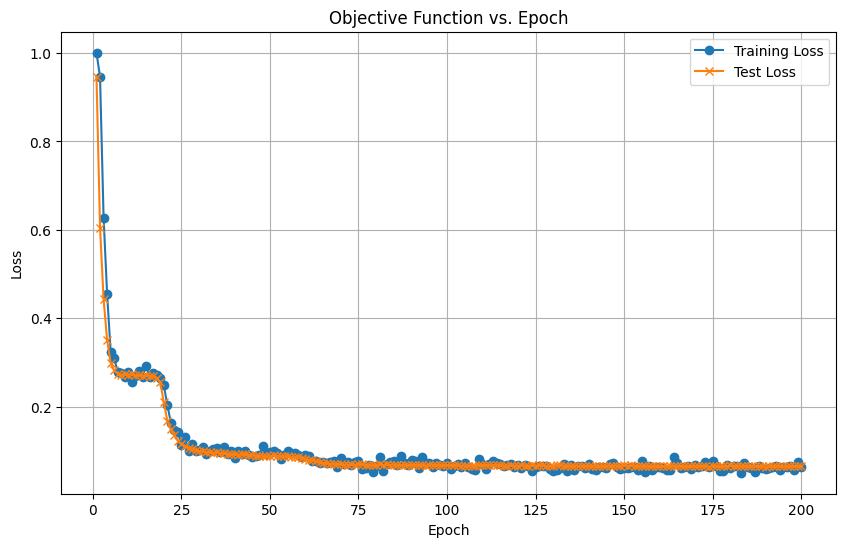

In [20]:
epochs = range(1, len(train_loss) + 1)  # Epochs are 1-based indexing

plt.figure(figsize=(10, 6))
plt.plot(epochs, plot_train_loss, label='Training Loss', marker='o')
plt.plot(epochs, test_loss, label='Test Loss', marker='x')
plt.title('Objective Function vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
os.getcwd()

'/Users/jeqcho/astro-205/grb'

In [22]:
nr = True
dft = False

fname = "final_dft_Autoencoder_"
if nr:
    fname += "Noise_Reduced_"
fname += f"{swift.res}res_"
fname += f'{"".join(str(b) for b in swift.n_bands)}bands_'
if dft:
    fname += f'DFT_'
# notes
fname += f'final-3-latent'


torch.save(AE.state_dict(), f'{fname}state_dict.pth')
# torch.save(AE, f'{fname}.pth')
print(f"Model saved to  f'{fname}state_dict.pth")

Model saved to  f'final_dft_Autoencoder_Noise_Reduced_64res_12345bands_final-3-latentstate_dict.pth


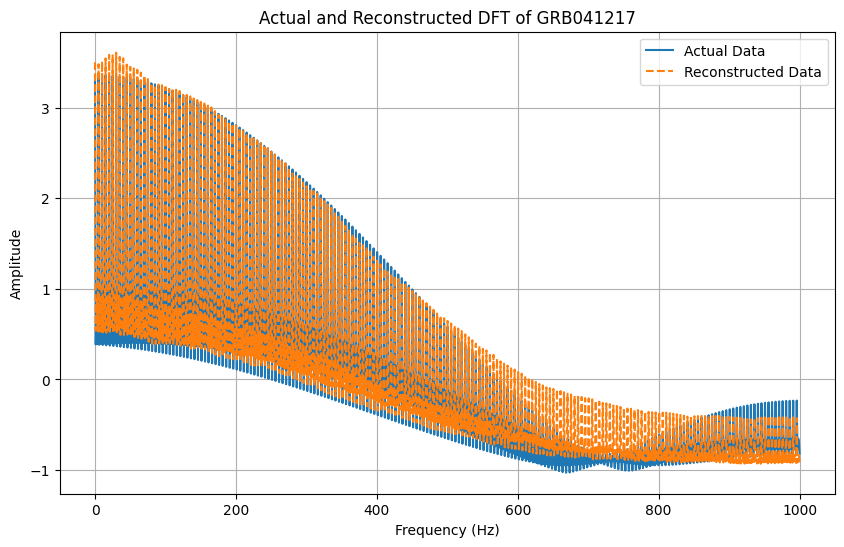

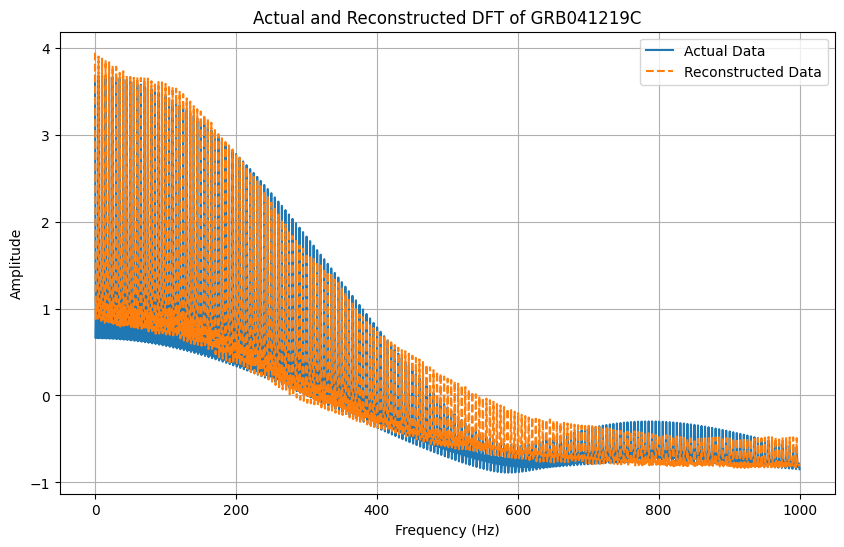

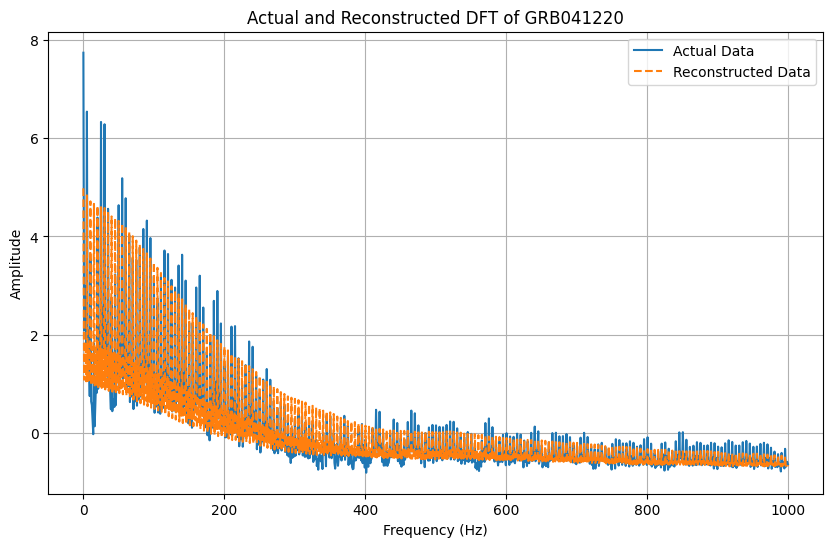

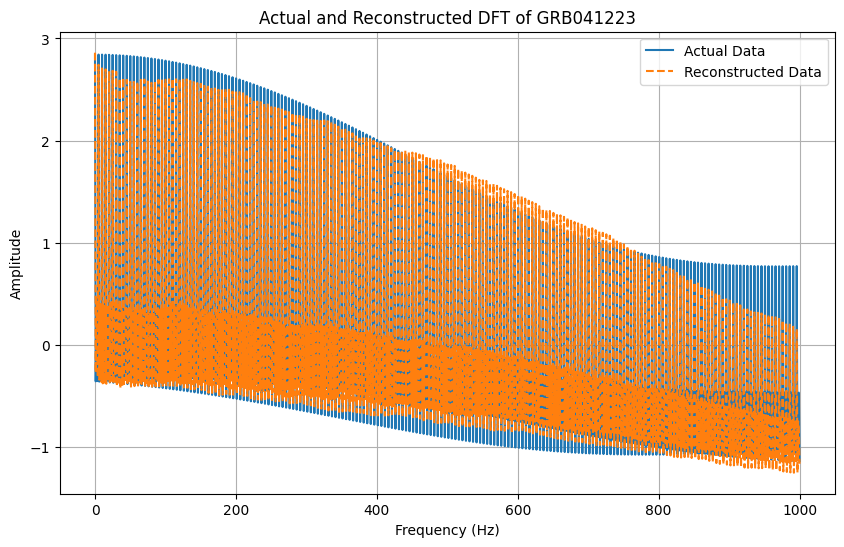

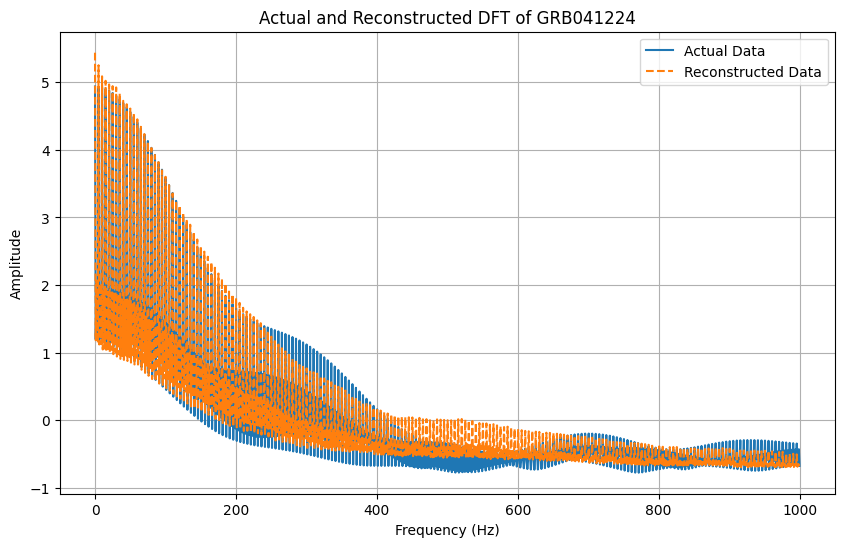

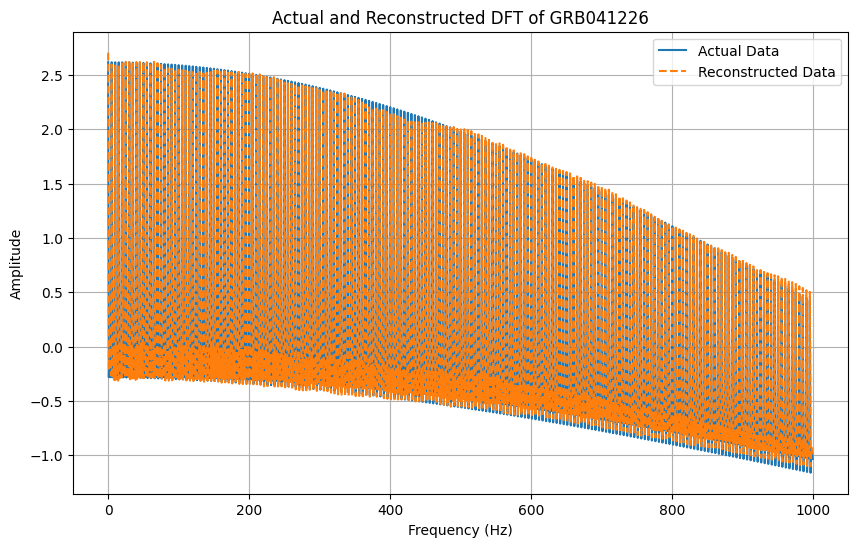

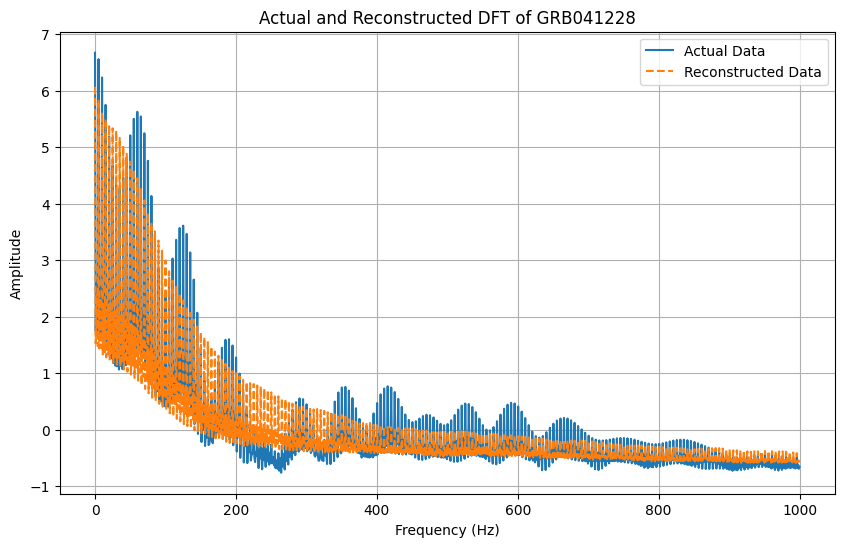

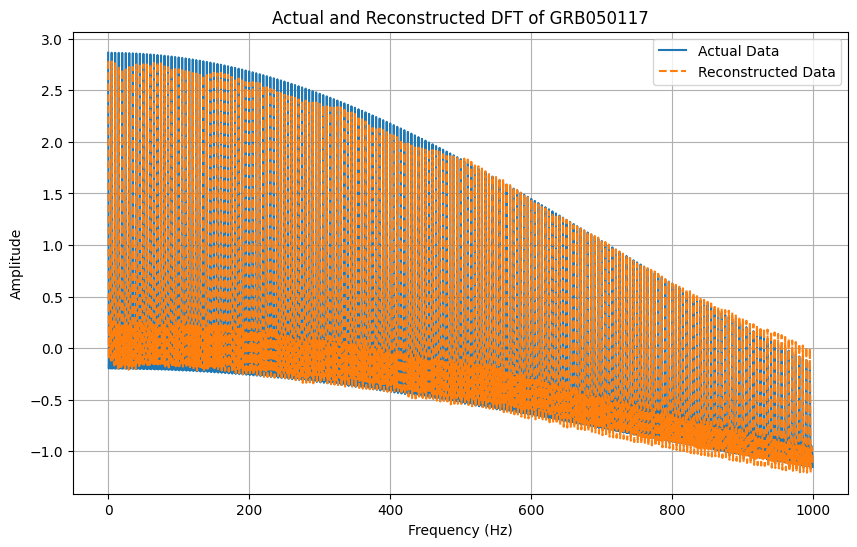

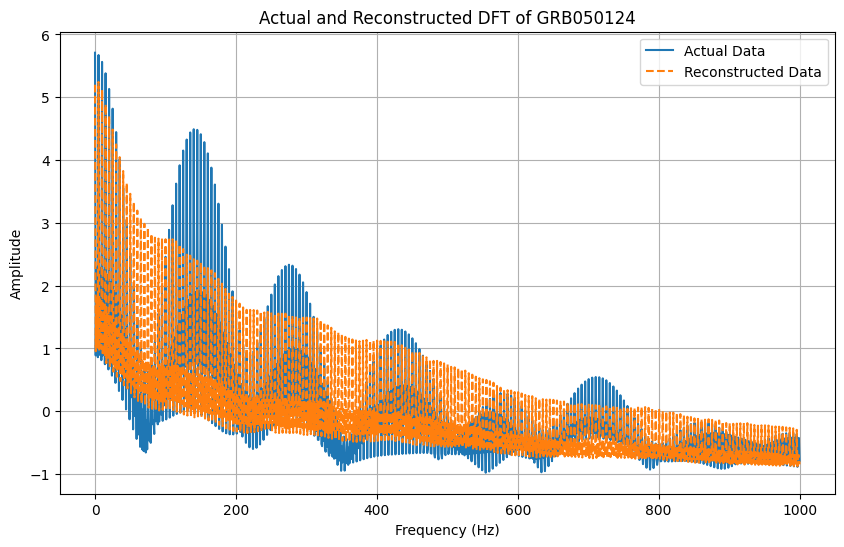

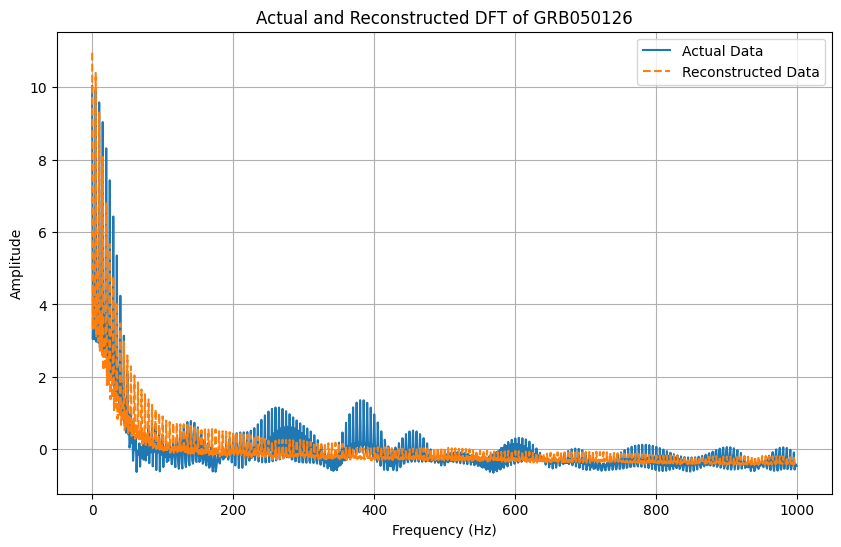

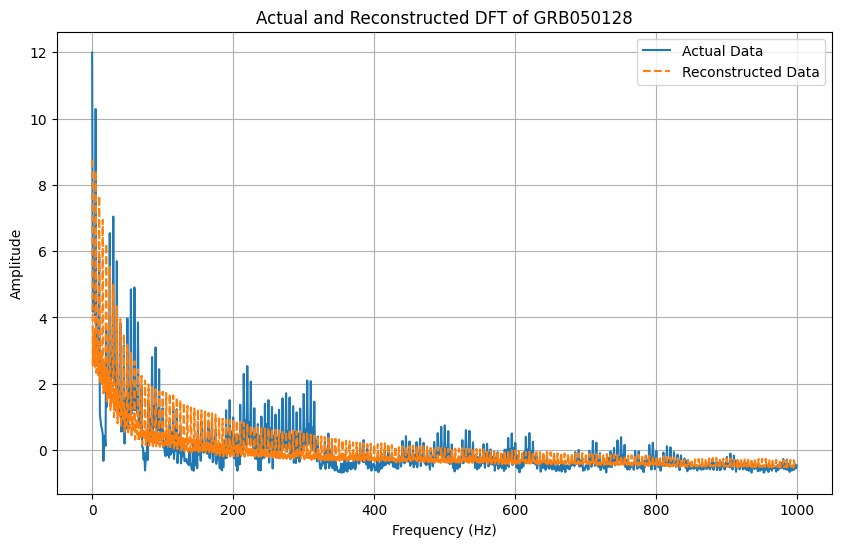

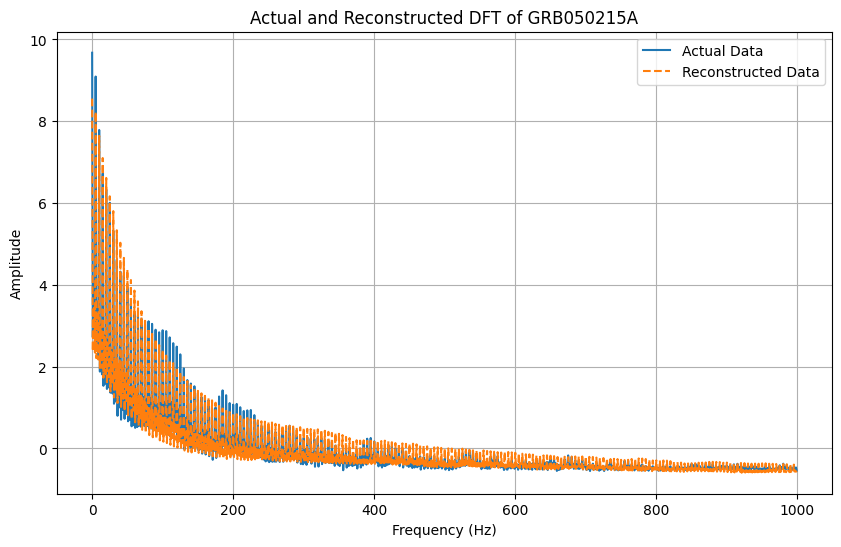

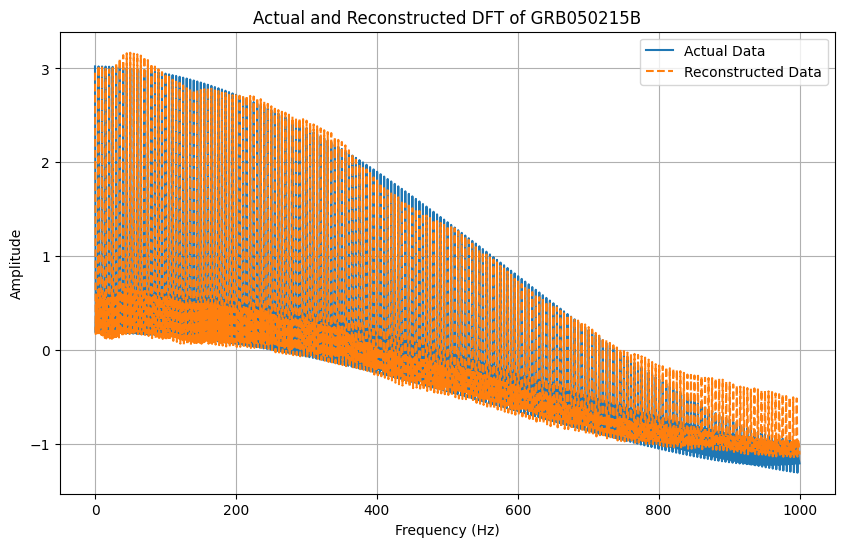

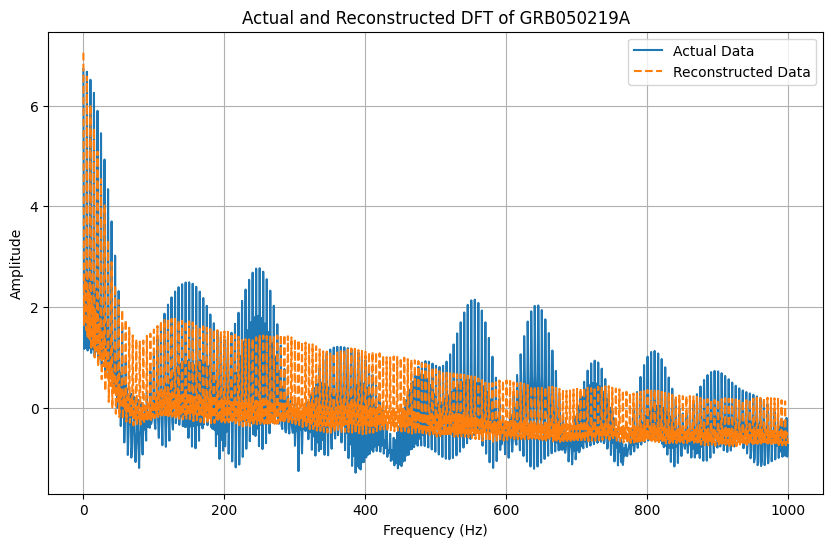

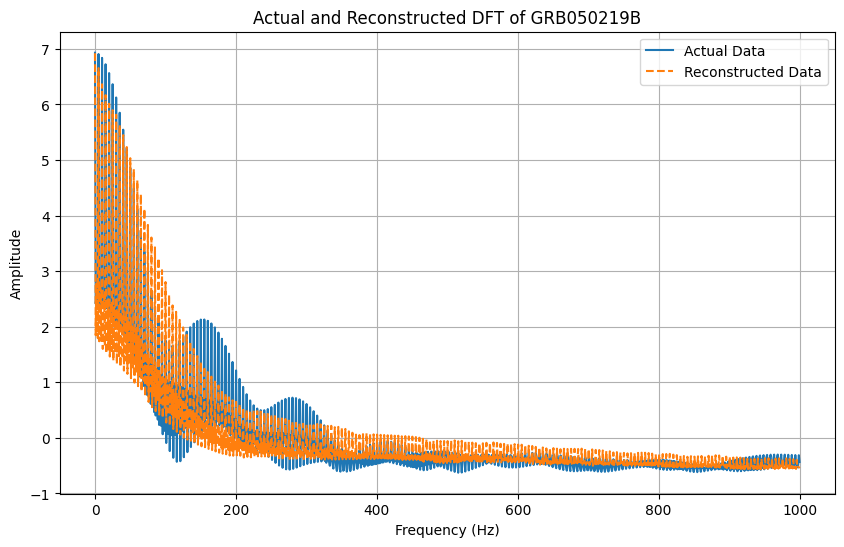

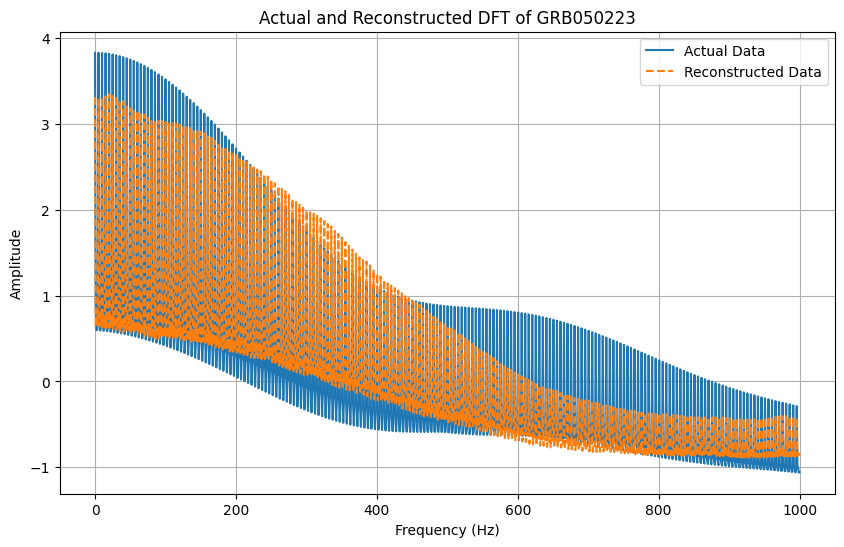

In [23]:
vis_loader = DataLoader(test_dataset, batch_size=16, shuffle=True) # get 16 random spectra

for X_batch, y_batch in vis_loader:
    # Simulated x-axis values for the spectrum
    x = np.linspace(0, features.shape[1], features.shape[1])
    
    with torch.no_grad():
        preds = AE(X_batch).detach()
    
    for i in range(len(X_batch)):
        plt.figure(figsize=(10, 6))
        plt.plot(x, X_batch[i].numpy(), label='Actual Data')  # Converting tensor to numpy array for plotting
        plt.plot(x, preds[i].numpy(), label='Reconstructed Data',linestyle='--')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Amplitude')
        plt.title(f'Actual and Reconstructed DFT of {grb_names[i]}')
        plt.legend()
        plt.grid(True)
    break # just need one batch of 16

In [24]:
preds2 = []
for x in normalized_features:
    with torch.no_grad():
        # Convert x from a NumPy array to a PyTorch tensor
        x_tensor = torch.tensor(x, dtype=torch.float32)
        
        # Add a batch dimension to x
        x_tensor = x_tensor.unsqueeze(0)
        preds2.append(AE.encoder(x_tensor).detach())

preds2 = torch.cat(preds2)
preds2

tensor([[ 45.3139,   4.2545, -16.0462],
        [ 56.6796,  -4.9310,  -5.0813],
        [ 43.0863,   3.4657, -18.1988],
        ...,
        [ 50.2695,   1.8876, -11.9742],
        [ 43.3207,  13.1520,   4.6531],
        [ 54.8176,   1.0355,   4.4117]])

In [25]:
mask = ~torch.isnan(preds2).any(dim=1)
preds2 = preds2[mask]
torch.sum(~mask)

tensor(0)

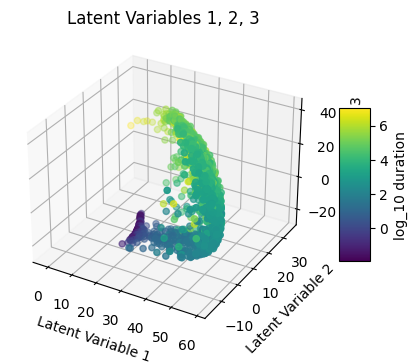

In [26]:
# Get all permutations of three columns out of five (0-based indices)
from itertools import combinations

perms = list(combinations(range(LATENT_SIZE), 3))

# Function to create subplots for permutations
def create_subplots(permutations, rows, cols):
    fig_count = len(permutations) // (rows * cols) + (1 if len(permutations) % (rows * cols) > 0 else 0)
    for f in range(fig_count):
        fig = plt.figure(figsize=(15, 10))
        for i in range(1, rows * cols + 1):
            if rows * cols * f + i - 1 < len(permutations):
                x, y, z = permutations[rows * cols * f + i - 1]
                ax = fig.add_subplot(rows, cols, i, projection='3d')
                # Use durations for coloring
                scatter = ax.scatter(preds2[:, x], preds2[:, y], preds2[:, z], c=np.log(durations[mask]), cmap='viridis')
                ax.set_xlabel(f'Latent Variable {x+1}')
                ax.set_ylabel(f'Latent Variable {y+1}')
                ax.set_zlabel(f'Latent Variable {z+1}')
                ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}')
        plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='log_10 duration')  # Add a colorbar with label
        plt.tight_layout()
        plt.show()

# Adjust the number of rows and columns based on how many subplots you want per figure
create_subplots(perms, 3, 3)  # Example: 9 plots per figure


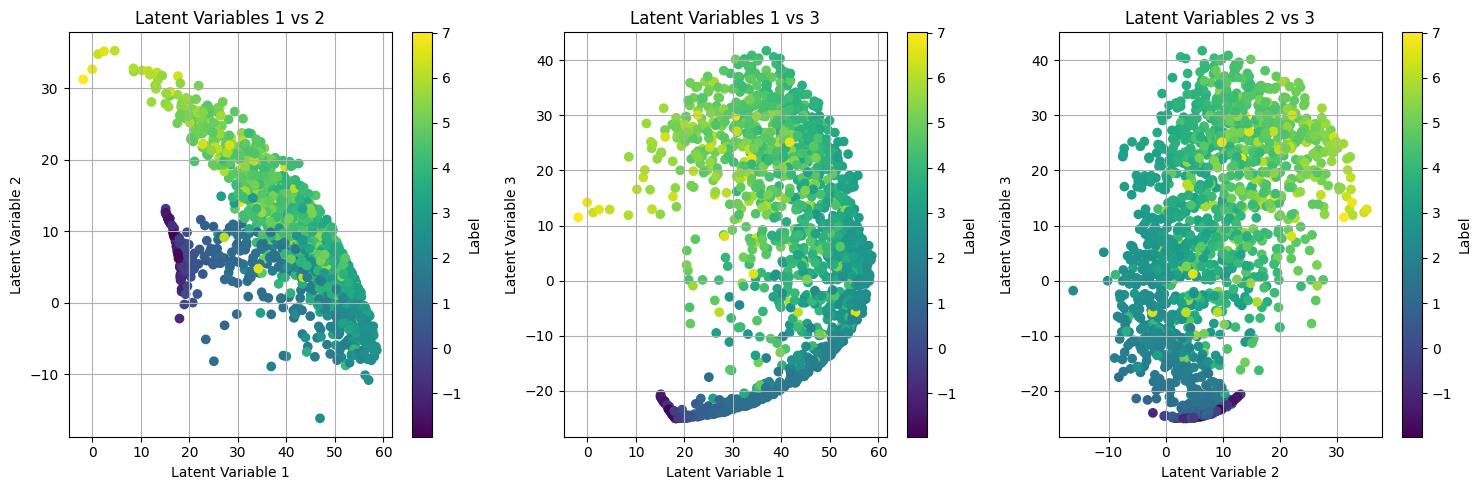

In [32]:
# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(combinations(range(LATENT_SIZE), 2))

# Create plots for all combinations
nrows = 1
ncols = 3
figsize = (15,5)
fig, axs = plt.subplots(nrows, ncols, figsize=figsize)  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    if nrows > 1:
        ax = axs[i//ncols, i%ncols]  # Determine the subplot for the current combo
    else:
        ax = axs[i%ncols]  # Determine the subplot for the current combo
    scatter = ax.scatter(preds2[:, idx1].numpy(), preds2[:, idx2].numpy(), c=np.log(durations[mask]), cmap='viridis')
    ax.set_title(f'Latent Variables {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Latent Variable {idx1+1}')
    ax.set_ylabel(f'Latent Variable {idx2+1}')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Label')

plt.tight_layout()
plt.show()

In [28]:
compact_mergers = [
    "GRB130603B",
    "GRB060614",
    "GRB080503",
    "GRB050709",
    "GRB050724",
    "GRB061006",
    "GRB070714B",
    "GRB160821B",
    "GRB111005A",
    "GRB150101B",
    "GRB070809",
    "GRB211211A",
    "GRB211227A",
    "GRB191019A",
    "GRB230307A"
]
indices = np.where(np.isin(grb_names, compact_mergers))[0]
mask_not_in_indices = ~np.isin(range(len(preds2)), indices)
# Initialize a dictionary to store the results with the merger names as keys
results = {merger: None for merger in compact_mergers}  # Start with None or any placeholder for not found

In [29]:
from sklearn.cluster import KMeans

encoded2 = preds2
kmeans2 = KMeans(n_clusters=2, random_state=205).fit(encoded2)
kmeans2

KMeans(n_clusters=2, random_state=205)

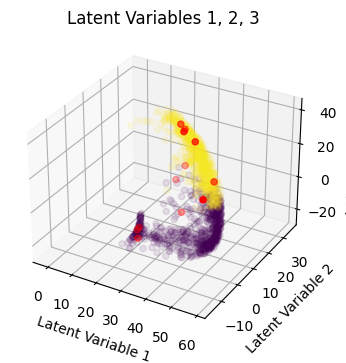

In [30]:
# Get all permutations of three columns out of five (0-based indices)

perms = list(combinations(range(LATENT_SIZE), 3))

# Function to create subplots for permutations
def create_subplots(permutations, rows, cols):
    fig_count = len(permutations) // (rows * cols) + (1 if len(permutations) % (rows * cols) > 0 else 0)
    for f in range(fig_count):
        fig = plt.figure(figsize=(15, 10))
        for i in range(1, rows * cols + 1):
            if rows * cols * f + i - 1 < len(permutations):
                x, y, z = permutations[rows * cols * f + i - 1]
                ax = fig.add_subplot(rows, cols, i, projection='3d')
                scatter = ax.scatter(preds2[mask_not_in_indices, x], preds2[mask_not_in_indices, y], preds2[mask_not_in_indices, z], 
                                     c=kmeans2.labels_[mask_not_in_indices], cmap='viridis',alpha=0.1)
                scatter = ax.scatter(preds2[indices, x], preds2[indices, y], preds2[indices, z], 
                                     c='r')
                ax.set_xlabel(f'Latent Variable {x+1}')
                ax.set_ylabel(f'Latent Variable {y+1}')
                ax.set_zlabel(f'Latent Variable {z+1}')
                ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}')

        plt.tight_layout()
        plt.show()

# Adjust the number of rows and columns based on how many subplots you want per figure
create_subplots(perms, 3, 3)  # Example: 9 plots per figure

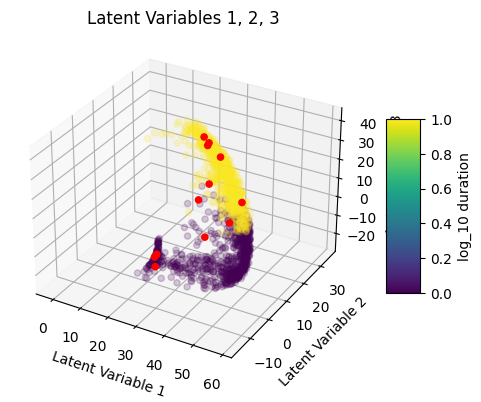

In [33]:
fig = plt.figure(figsize=(6, 4))
x, y, z = [0,1,2]
ax = fig.add_subplot(projection='3d')
# Use durations for coloring
scatter = ax.scatter(preds2[mask_not_in_indices, x], preds2[mask_not_in_indices, y], preds2[mask_not_in_indices, z], 
                     c=kmeans2.labels_[mask_not_in_indices], cmap='viridis',alpha=0.2)
scatter = ax.scatter(preds2[indices, x], preds2[indices, y], preds2[indices, z], c='red',alpha=1)
ax.set_xlabel(f'Latent Variable {x+1}')
ax.set_ylabel(f'Latent Variable {y+1}')
ax.set_zlabel(f'Latent Variable {z+1}')
ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}')
plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='log_10 duration')  # Add a colorbar with label
plt.tight_layout()
plt.show()

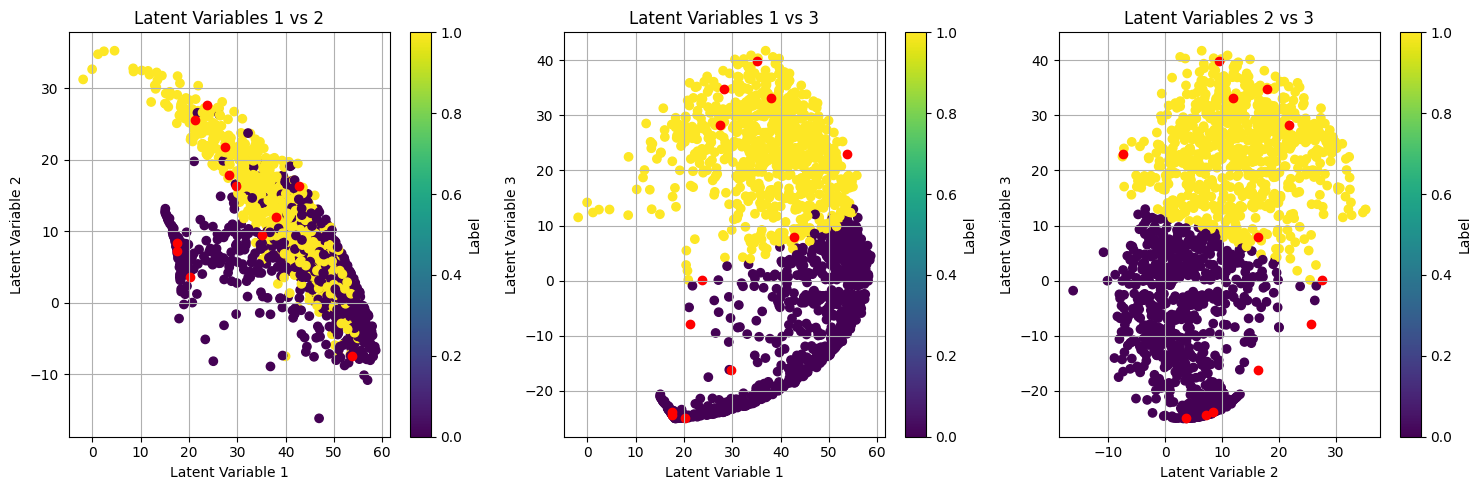

In [34]:
# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(combinations(range(LATENT_SIZE), 2))

# Create plots for all combinations
fig, axs = plt.subplots(nrows, ncols, figsize=figsize)  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    if nrows > 1:
        ax = axs[i//ncols, i%ncols]  # Determine the subplot for the current combo
    else:
        ax = axs[i%ncols]  # Determine the subplot for the current combo
    scatter = ax.scatter(preds2[mask_not_in_indices, idx1].numpy(), preds2[mask_not_in_indices, idx2].numpy(), 
                         c=kmeans2.labels_[mask_not_in_indices], cmap='viridis')
    scatter = ax.scatter(preds2[indices, idx1], preds2[indices, idx2], c='red')
    ax.set_title(f'Latent Variables {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Latent Variable {idx1+1}')
    ax.set_ylabel(f'Latent Variable {idx2+1}')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Label')

plt.tight_layout()
plt.show()

In [35]:
encoded = preds2

In [36]:
data_loaded = np.load(os.path.join(swift.results_path, f'SWIFT_Noise_Reduced_data_{swift.res}res_{"".join(str(b) for b in swift.n_bands)}bands_DFT_True.npz'))
names_64ms, features_64ms = data_loaded['names'], data_loaded['data']

In [37]:
names_64ms = names_64ms[mask]

In [38]:
# Values
values = np.array([0, 1])

# Normalize the values to the range of the colormap
normalized_values = values / max(values)

# Get the corresponding colormap
cmap = plt.cm.get_cmap('viridis')

# Apply the colormap to normalized values
colors = cmap(normalized_values)

# Print color values
for value, color in zip(values, colors):
    print(f"Value {value} has color: {color}")

Value 0 has color: [0.267004 0.004874 0.329415 1.      ]
Value 1 has color: [0.993248 0.906157 0.143936 1.      ]


In [39]:
colors

array([[0.267004, 0.004874, 0.329415, 1.      ],
       [0.993248, 0.906157, 0.143936, 1.      ]])

Finding Durations: 100%|█████████████████████| 754/754 [00:08<00:00, 84.42GRB/s]


Text(0.5, 1.0, 'Frequency Histogram of Duration of GRBs using K=2')

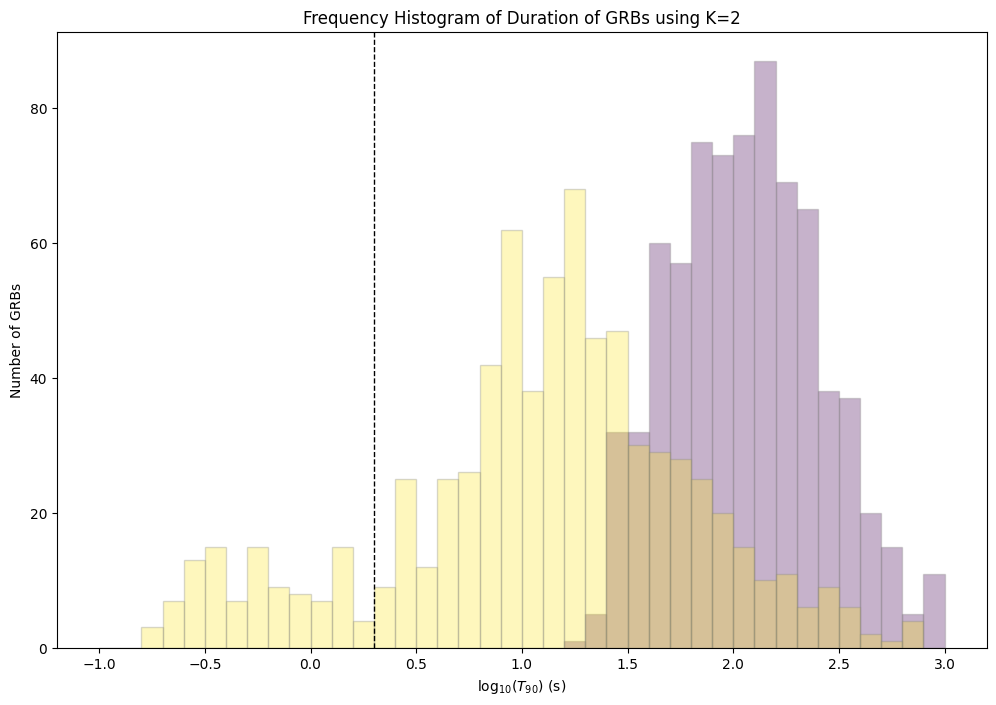

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
match = kmeans2.labels_==1
match2 = kmeans2.labels_==0
names1 = names_64ms[match]
names2 = names_64ms[match2]
swift.duration_histogram(names=[names1, names2], alpha=0.3, color_groups=colors, ax=ax)
ax.axvline(x=np.log10(2), c='k', ls='--', linewidth=1)
ax.set_xlabel(r'log$_{10}(T_{90})$ (s)')
ax.set_ylabel('Number of GRBs')
ax.set_title('Frequency Histogram of Duration of GRBs using K=2')

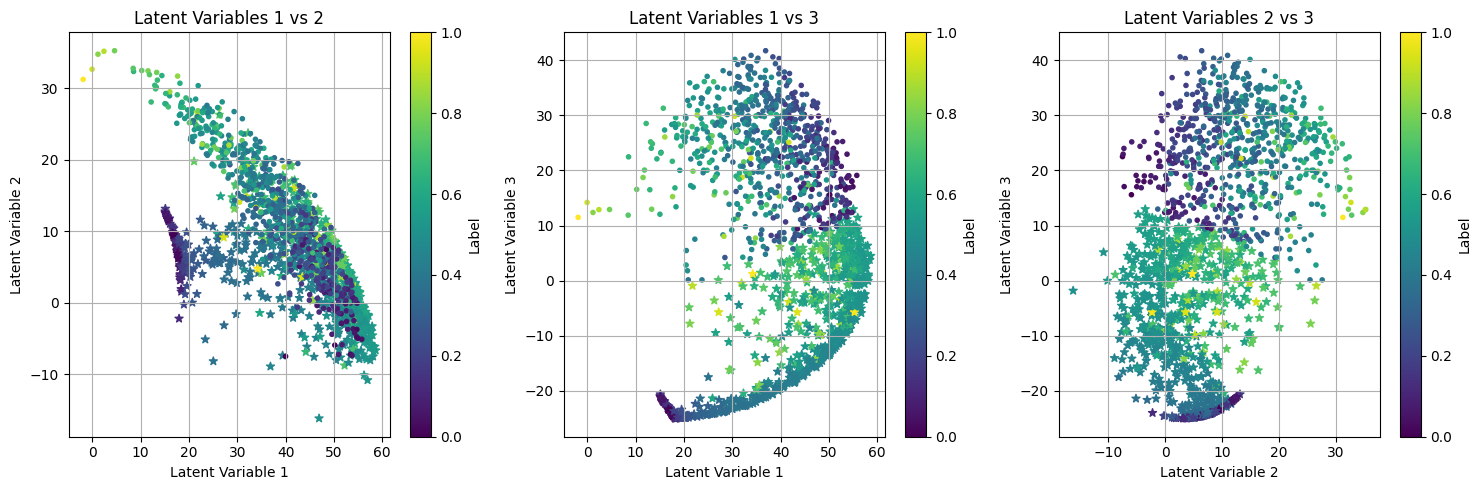

In [56]:
# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(combinations(range(LATENT_SIZE), 2))

labls = kmeans2.labels_
centers = kmeans2.cluster_centers_
num_class = max(labls)+1
labls_array = np.array([label.item() for label in labls])
description = ['g1','g2']

markers = ['*', '.']
edgecolors = ['red', 'black']

fig, axs = plt.subplots(nrows, ncols, figsize=figsize)  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    if nrows > 1:
        ax = axs[i//ncols, i%ncols]  # Determine the subplot for the current combo
    else:
        ax = axs[i%ncols]  # Determine the subplot for the current combo
    for cluster in range(num_class):
        pred_class_mask = labls == cluster
        ax.scatter(encoded[pred_class_mask,idx1], encoded[pred_class_mask,idx2], 
                   c=np.log(durations[pred_class_mask]), marker=markers[cluster], cmap='viridis')

    # cluster center
    # for idx, center in enumerate(centers):
        # ax.scatter(center[idx1],center[idx2], cmap='viridis', marker='X', s=100, edgecolors='red')

    
    ax.set_title(f'Latent Variables {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Latent Variable {idx1+1}')
    ax.set_ylabel(f'Latent Variable {idx2+1}')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Label')

plt.tight_layout()
plt.show()

In [42]:
import numpy as np


# Exploring the array
print("Shape of the array:", durations[mask].shape)
print("Data type of the array:", durations[mask].dtype)
print("Number of dimensions:", durations[mask].ndim)
print("Total number of elements:", durations[mask].size)

# Describing the durations[mask]
print("Mean of the array:", np.mean(durations[mask]))
print("Standard deviation:", np.std(durations[mask]))
print("Minimum value:", np.min(durations[mask]))
print("Maximum value:", np.max(durations[mask]))
print("25th percentile:", np.percentile(durations[mask], 25))
print("Median:", np.median(durations[mask]))
print("75th percentile:", np.percentile(durations[mask], 75))
print("90th percentile:", np.percentile(durations[mask], 90))
print("95th percentile:", np.percentile(durations[mask], 95))
print("99th percentile:", np.percentile(durations[mask], 99))

Shape of the array: (1513,)
Data type of the array: float64
Number of dimensions: 1
Total number of elements: 1513
Mean of the array: 76.21325842696629
Standard deviation: 107.63104972105164
Minimum value: 0.14
Maximum value: 1104.7520000000002
25th percentile: 11.904
Median: 41.0
75th percentile: 97.69999999999999
90th percentile: 181.992
95th percentile: 270.82320000000004
99th percentile: 545.7420799999968


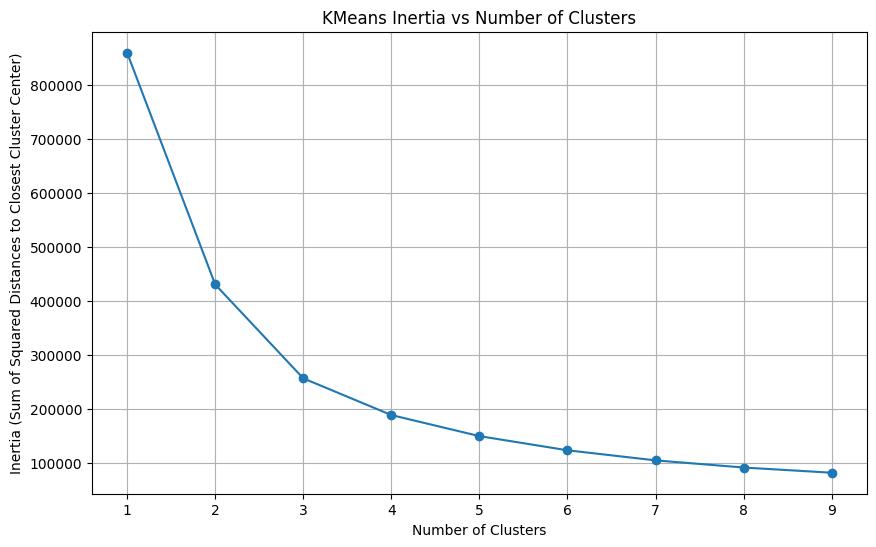

In [43]:
# Try different numbers of clusters
num_clusters = range(1, 10)  # You can adjust the range as needed
inertias = []

for k in num_clusters:
    kmeans = KMeans(n_clusters=k, random_state=205)
    kmeans.fit(encoded2)
    inertias.append(kmeans.inertia_)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(num_clusters, inertias, marker='o')
plt.title('KMeans Inertia vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Sum of Squared Distances to Closest Cluster Center)')
plt.grid(True)
plt.show()

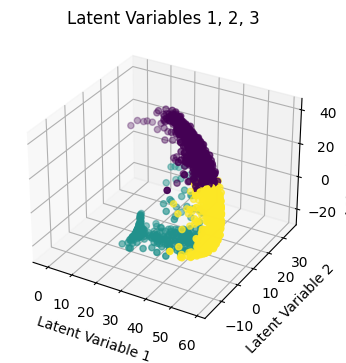

In [44]:
kmeans3 = KMeans(n_clusters=3, random_state=205).fit(encoded2)

# Function to create subplots for permutations
def create_subplots(permutations, rows, cols):
    fig_count = len(permutations) // (rows * cols) + (1 if len(permutations) % (rows * cols) > 0 else 0)
    for f in range(fig_count):
        fig = plt.figure(figsize=(15, 10))
        for i in range(1, rows * cols + 1):
            if rows * cols * f + i - 1 < len(permutations):
                x, y, z = permutations[rows * cols * f + i - 1]
                ax = fig.add_subplot(rows, cols, i, projection='3d')
                scatter = ax.scatter(preds2[:, x], preds2[:, y], preds2[:, z], c=kmeans3.labels_, cmap='viridis')
                ax.set_xlabel(f'Latent Variable {x+1}')
                ax.set_ylabel(f'Latent Variable {y+1}')
                ax.set_zlabel(f'Latent Variable {z+1}')
                ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}')

        plt.tight_layout()
        plt.show()

# Adjust the number of rows and columns based on how many subplots you want per figure
create_subplots(perms, 3, 3)  # Example: 9 plots per figure

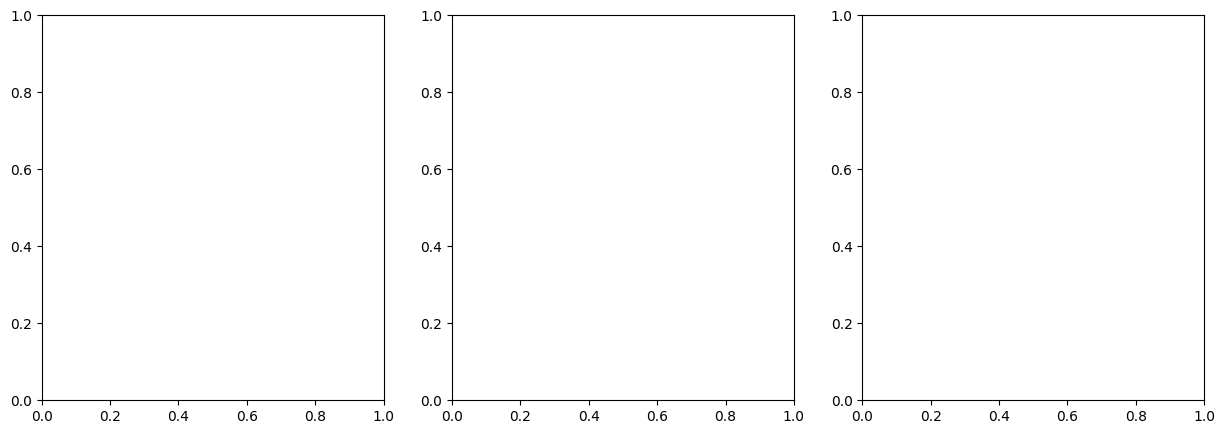

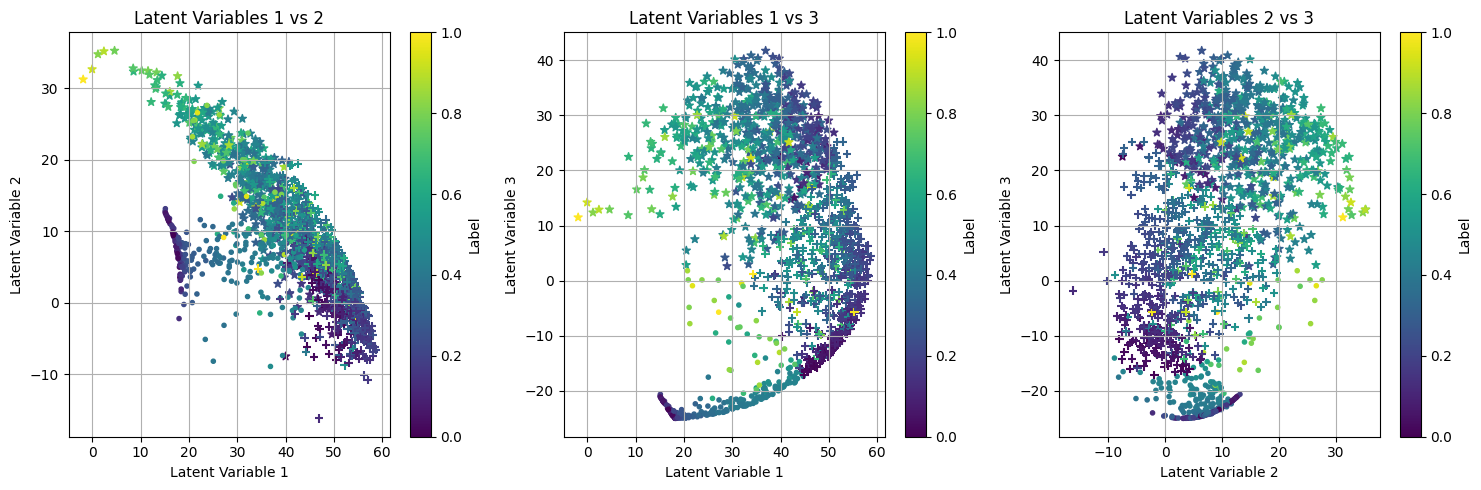

In [57]:
# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(combinations(range(LATENT_SIZE), 2))

# Create plots for all combinations
fig, axs = plt.subplots(nrows, ncols, figsize=figsize)  # Adjust subplot grid as needed

labls = kmeans3.labels_
centers = kmeans3.cluster_centers_
num_class = max(labls)+1
labls_array = np.array([label.item() for label in labls])
description = ['g1','g2','g3']

markers = ['*', '.','+']
edgecolors = ['red', 'black']


fig, axs = plt.subplots(nrows, ncols, figsize=figsize)  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    if nrows > 1:
        ax = axs[i//ncols, i%ncols]  # Determine the subplot for the current combo
    else:
        ax = axs[i%ncols]  # Determine the subplot for the current combo
    for cluster in range(num_class):
        pred_class_mask = labls == cluster
        ax.scatter(encoded[pred_class_mask,idx1], encoded[pred_class_mask,idx2], 
                   c=np.log(durations[pred_class_mask]), marker=markers[cluster], cmap='viridis')

    # cluster center
    # for idx, center in enumerate(centers):
        # ax.scatter(center[idx1],center[idx2], cmap='viridis', marker='X', s=100, edgecolors='red')

    
    ax.set_title(f'Latent Variables {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Latent Variable {idx1+1}')
    ax.set_ylabel(f'Latent Variable {idx2+1}')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Label')

plt.tight_layout()
plt.show()

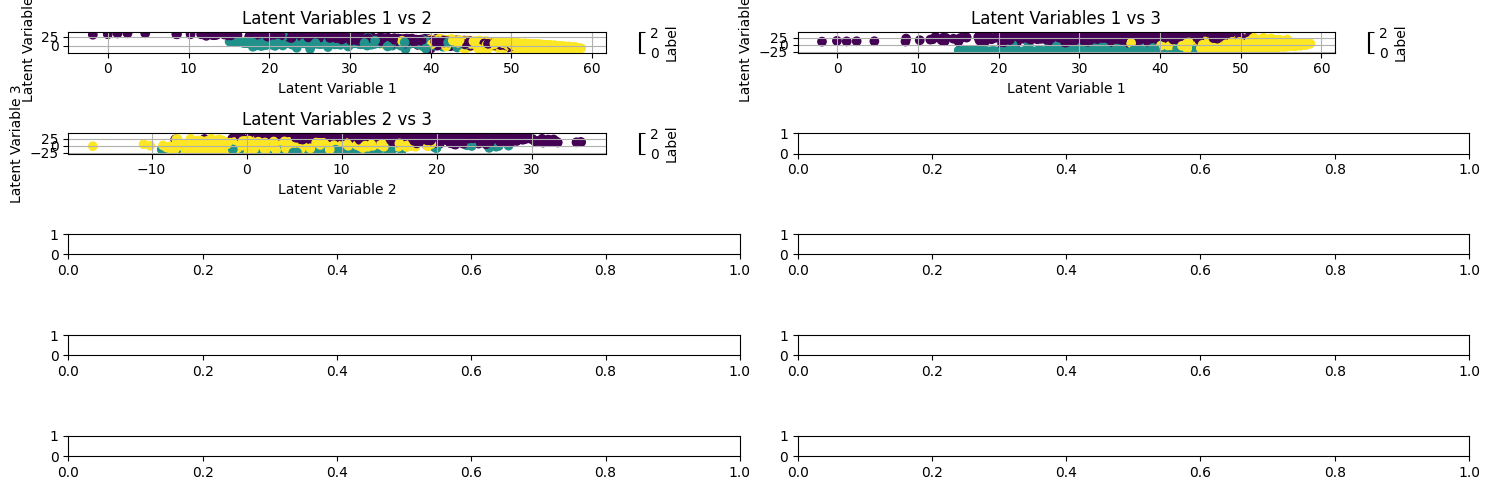

In [46]:
# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(combinations(range(LATENT_SIZE), 2))

# Create plots for all combinations
fig, axs = plt.subplots(5, 2, figsize=figsize)  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    ax = axs[i//2, i%2]  # Determine the subplot for the current combo
    scatter = ax.scatter(preds2[:, idx1].numpy(), preds2[:, idx2].numpy(), c=kmeans3.labels_, cmap='viridis')
    ax.set_title(f'Latent Variables {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Latent Variable {idx1+1}')
    ax.set_ylabel(f'Latent Variable {idx2+1}')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Label')

plt.tight_layout()
plt.show()

In [47]:
# Values
values = np.arange(3)

# Normalize the values to the range of the colormap
normalized_values = values / max(values)

# Get the corresponding colormap
cmap = plt.cm.get_cmap('viridis')

# Apply the colormap to normalized values
colors = cmap(normalized_values)

# Print color values
for value, color in zip(values, colors):
    print(f"Value {value} has color: {color}")

Value 0 has color: [0.267004 0.004874 0.329415 1.      ]
Value 1 has color: [0.127568 0.566949 0.550556 1.      ]
Value 2 has color: [0.993248 0.906157 0.143936 1.      ]


Finding Durations: 100%|█████████████████████| 613/613 [00:06<00:00, 93.13GRB/s]


Text(0.5, 1.0, 'Frequency Histogram of Duration of GRBs using K=3')

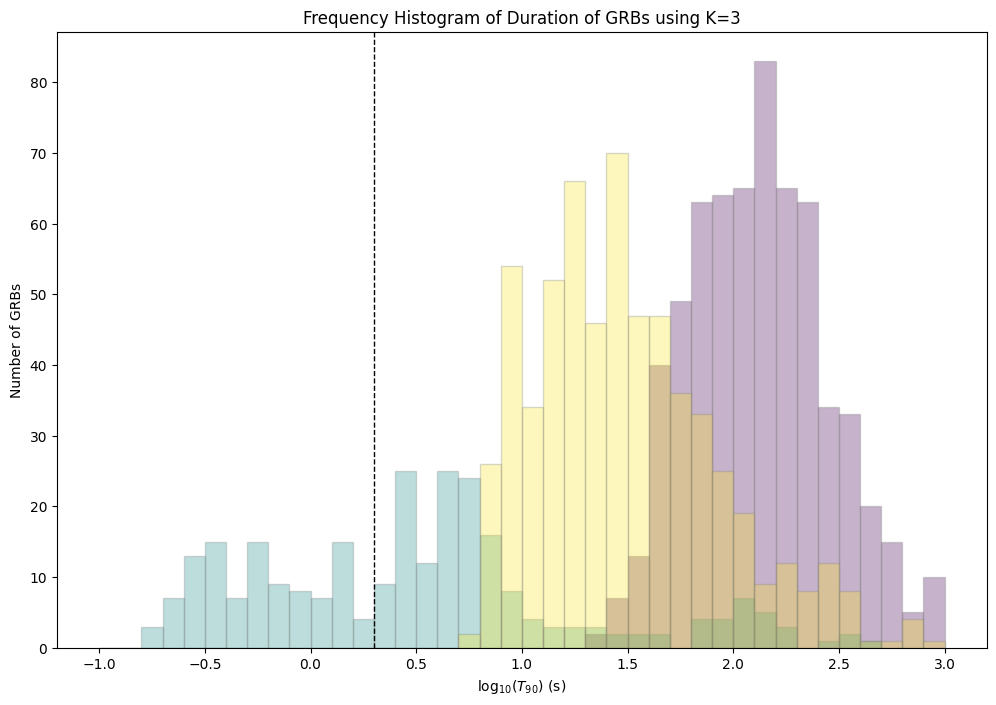

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
match1 = kmeans3.labels_==0
match2 = kmeans3.labels_==1
match3 = kmeans3.labels_==2
names1 = names_64ms[match1]
names2 = names_64ms[match2]
names3 = names_64ms[match3]
swift.duration_histogram(names=[names1, names2, names3], alpha=0.3, color_groups=colors, ax=ax)
ax.axvline(x=np.log10(2), c='k', ls='--', linewidth=1)
ax.set_xlabel(r'log$_{10}(T_{90})$ (s)')
ax.set_ylabel('Number of GRBs')
ax.set_title('Frequency Histogram of Duration of GRBs using K=3')

In [49]:
torch.sum(~mask)

tensor(0)

In [50]:
# Find indices for each item in compact_mergers within names_64ms
for merger in compact_mergers:
    _indices = np.where(names_64ms == merger)[0]
    results[merger] = _indices[0] if _indices.size > 0 else -1  # Store index if found, else store -1

# Printing the results
for key, value in results.items():
    print(f"{key}: {kmeans2.labels_[value]}")

GRB130603B: 0
GRB060614: 1
GRB080503: 1
GRB050709: 0
GRB050724: 1
GRB061006: 0
GRB070714B: 0
GRB160821B: 0
GRB111005A: 1
GRB150101B: 0
GRB070809: 0
GRB211211A: 1
GRB211227A: 1
GRB191019A: 1
GRB230307A: 0


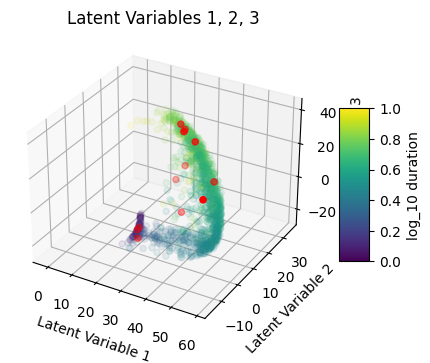

In [51]:
# Get all permutations of three columns out of five (0-based indices)
perms = list(combinations(range(LATENT_SIZE), 3))

# Function to create subplots for permutations
def create_subplots(permutations, rows, cols):
    fig_count = len(permutations) // (rows * cols) + (1 if len(permutations) % (rows * cols) > 0 else 0)
    for f in range(fig_count):
        fig = plt.figure(figsize=(15, 10))
        for i in range(1, rows * cols + 1):
            if rows * cols * f + i - 1 < len(permutations):
                x, y, z = permutations[rows * cols * f + i - 1]
                ax = fig.add_subplot(rows, cols, i, projection='3d')
                # Use durations for coloring
                scatter = ax.scatter(preds2[mask_not_in_indices, x], preds2[mask_not_in_indices, y], preds2[mask_not_in_indices, z], c=np.log(durations[mask_not_in_indices]), cmap='viridis',alpha=0.1)
                scatter = ax.scatter(preds2[indices, x], preds2[indices, y], preds2[indices, z], c='red')
                ax.set_xlabel(f'Latent Variable {x+1}')
                ax.set_ylabel(f'Latent Variable {y+1}')
                ax.set_zlabel(f'Latent Variable {z+1}')
                ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}')
        plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='log_10 duration')  # Add a colorbar with label
        plt.tight_layout()
        plt.show()

# Adjust the number of rows and columns based on how many subplots you want per figure
create_subplots(perms, 3, 3)  # Example: 9 plots per figure


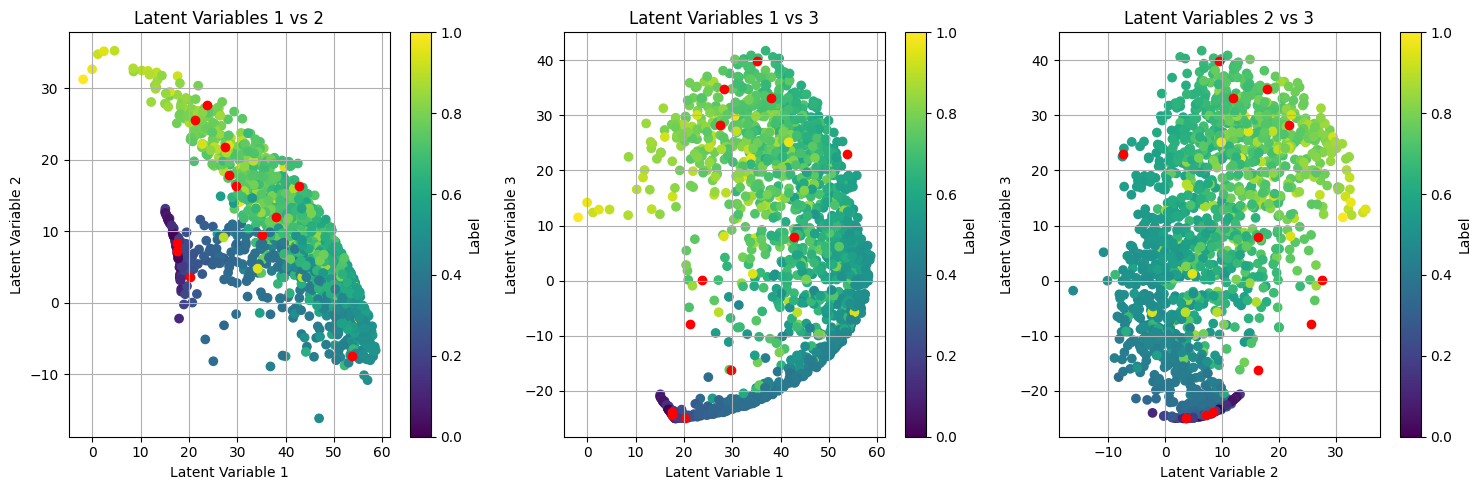

In [58]:
# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(combinations(range(LATENT_SIZE), 2))


fig, axs = plt.subplots(nrows, ncols, figsize=figsize)  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    if nrows > 1:
        ax = axs[i//ncols, i%ncols]  # Determine the subplot for the current combo
    else:
        ax = axs[i%ncols]  # Determine the subplot for the current combo
    scatter = ax.scatter(preds2[mask_not_in_indices, idx1].numpy(), preds2[mask_not_in_indices, idx2].numpy(), c=np.log(durations[mask_not_in_indices]), cmap='viridis')
    scatter = ax.scatter(preds2[indices, idx1], preds2[indices, idx2], c='red')
    ax.set_title(f'Latent Variables {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Latent Variable {idx1+1}')
    ax.set_ylabel(f'Latent Variable {idx2+1}')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Label')

plt.tight_layout()
plt.show()

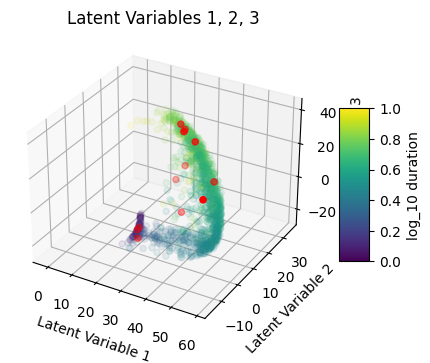

In [53]:
# Get all permutations of three columns out of five (0-based indices)
perms = list(combinations(range(LATENT_SIZE), 3))

# Function to create subplots for permutations
def create_subplots(permutations, rows, cols):
    fig_count = len(permutations) // (rows * cols) + (1 if len(permutations) % (rows * cols) > 0 else 0)
    for f in range(fig_count):
        fig = plt.figure(figsize=(15, 10))
        for i in range(1, rows * cols + 1):
            if rows * cols * f + i - 1 < len(permutations):
                x, y, z = permutations[rows * cols * f + i - 1]
                ax = fig.add_subplot(rows, cols, i, projection='3d')
                # Use durations for coloring
                scatter = ax.scatter(preds2[mask_not_in_indices, x], preds2[mask_not_in_indices, y], preds2[mask_not_in_indices, z], c=np.log(durations[mask_not_in_indices]), cmap='viridis',alpha=0.1)
                scatter = ax.scatter(preds2[indices, x], preds2[indices, y], preds2[indices, z], c='red')
                ax.set_xlabel(f'Latent Variable {x+1}')
                ax.set_ylabel(f'Latent Variable {y+1}')
                ax.set_zlabel(f'Latent Variable {z+1}')
                ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}')
        plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='log_10 duration')  # Add a colorbar with label
        plt.tight_layout()
        plt.show()

# Adjust the number of rows and columns based on how many subplots you want per figure
create_subplots(perms, 3, 3)  # Example: 9 plots per figure


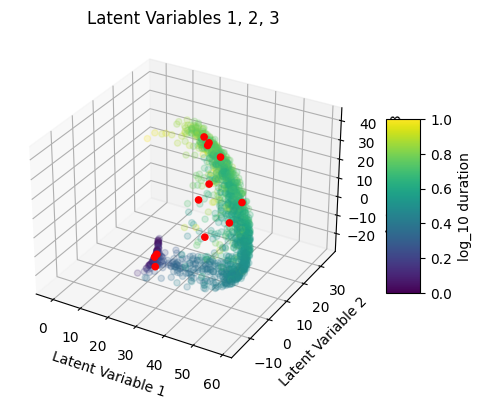

In [59]:
fig = plt.figure(figsize=(6, 4))
x, y, z = [0,1,2]
ax = fig.add_subplot(projection='3d')
# Use durations for coloring
scatter = ax.scatter(preds2[mask_not_in_indices, x], preds2[mask_not_in_indices, y], preds2[mask_not_in_indices, z], 
                     c=np.log(durations[mask_not_in_indices]), cmap='viridis',alpha=0.2)
scatter = ax.scatter(preds2[indices, x], preds2[indices, y], preds2[indices, z], c='red',alpha=1)
ax.set_xlabel(f'Latent Variable {x+1}')
ax.set_ylabel(f'Latent Variable {y+1}')
ax.set_zlabel(f'Latent Variable {z+1}')
ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}')
plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='log_10 duration')  # Add a colorbar with label
plt.tight_layout()
plt.show()

In [ ]:
# Define the viewing angles
viewing_angles = [
    (30, 45),
    (60, 120),
    (90, 210)
]
x, y, z = [1,2,3]
# Loop over each angle pair and create a separate plot
for i, (elev, azim) in enumerate(viewing_angles, start=1):
    # Square figsize for clear 3D plots
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(projection='3d')

    # Use durations for coloring
    scatter = ax.scatter(preds2[mask_not_in_indices, x], preds2[mask_not_in_indices, y], preds2[mask_not_in_indices, z], 
                         c=np.log(durations[mask_not_in_indices]), cmap='viridis', alpha=0.5)
    # Highlighted points
    scatter_highlight = ax.scatter(preds2[indices, x], preds2[indices, y], preds2[indices, z], c='red', alpha=1)

    # Set labels and title
    ax.set_xlabel(f'Latent Variable {x+1}', fontsize=10)
    ax.set_ylabel(f'Latent Variable {y+1}', fontsize=10)
    ax.set_zlabel(f'Latent Variable {z+1}', fontsize=10)
    ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}', fontsize=12)

    # Set the view angle
    ax.view_init(elev=elev, azim=azim)

    # Add a colorbar with label
    colorbar = plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='log_10 duration')
    colorbar.ax.tick_params(labelsize=8)

    plt.tight_layout()
    plt.show()

    # If you want to save the figure
    # plt.savefig(f'3d_plot_view_{i}.png', bbox_inches='tight')


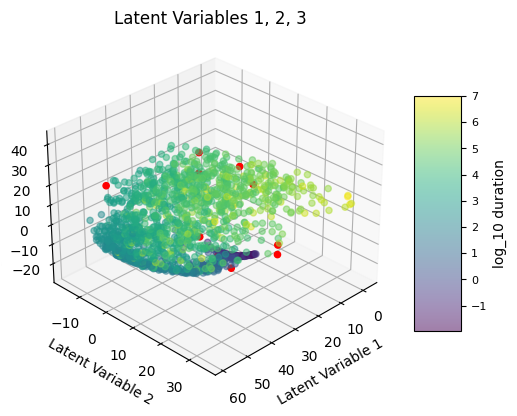

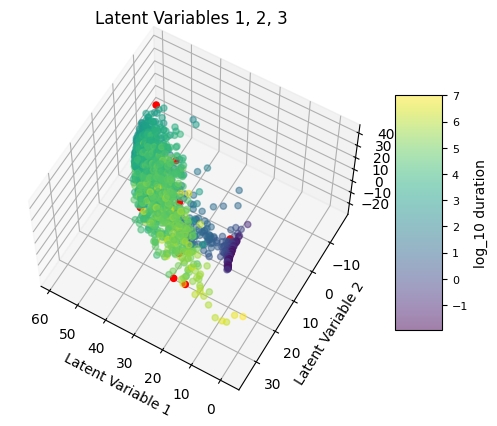

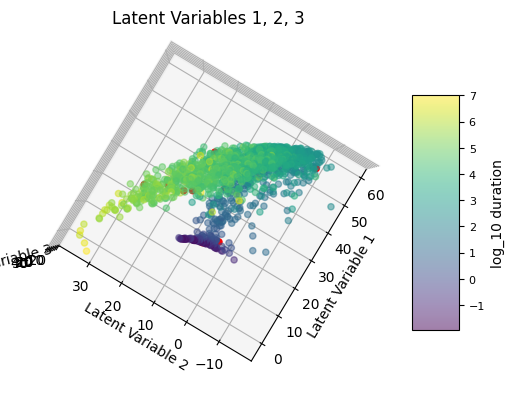

In [61]:
# Define the viewing angles
viewing_angles = [
    (30, 45),
    (60, 120),
    (90, 210)
]
x, y, z = [0,1,2]
# Loop over each angle pair and create a separate plot
for i, (elev, azim) in enumerate(viewing_angles, start=1):
    # Square figsize for clear 3D plots
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(projection='3d')

    # Use durations for coloring
    scatter = ax.scatter(preds2[mask_not_in_indices, x], preds2[mask_not_in_indices, y], preds2[mask_not_in_indices, z], 
                         c=np.log(durations[mask_not_in_indices]), cmap='viridis', alpha=0.5)
    # Highlighted points
    scatter_highlight = ax.scatter(preds2[indices, x], preds2[indices, y], preds2[indices, z], c='red', alpha=1)

    # Set labels and title
    ax.set_xlabel(f'Latent Variable {x+1}', fontsize=10)
    ax.set_ylabel(f'Latent Variable {y+1}', fontsize=10)
    ax.set_zlabel(f'Latent Variable {z+1}', fontsize=10)
    ax.set_title(f'Latent Variables {x+1}, {y+1}, {z+1}', fontsize=12)

    # Set the view angle
    ax.view_init(elev=elev, azim=azim)

    # Add a colorbar with label
    colorbar = plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='log_10 duration')
    colorbar.ax.tick_params(labelsize=8)

    plt.tight_layout()
    plt.show()

    # If you want to save the figure
    # plt.savefig(f'3d_plot_view_{i}.png', bbox_inches='tight')
